<a href="https://colab.research.google.com/github/Kcurr01/HUT_Research/blob/main/S1_Captum_Optuna_VAE_3_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
Instalation 
---

In [ ]:
# !pip install captum
# !pip install umap-learn
# !pip install datashader
# !pip install bokeh
# !pip install holoviews
!pip install tensorboardX
!pip install optuna
!pip install captum

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---
VAE Experiment 1 **[]** 2/27
---

In [ ]:
import torch   
import torch.nn as nn                          
import torch.nn.functional as F                
import torch.optim as optim   
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data

import pandas as pd 
import numpy as np
import os                             

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns    

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

import torchvision
from torchvision import datasets

#based on sensor data can you determine the stimulus that is currently in use?
import optuna
from optuna.pruners import ThresholdPruner
from optuna import TrialPruned

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/Subject_1/S1_E1_A1.csv")
#drops all 0 labels (no label)
indices_to_drop = df[df["stimulus"] == 0].index
df.drop(indices_to_drop, inplace=True)

#Removes number of features from data
# df.drop('Cyber Glove (angles of the joints) Sensor 1', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 2', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 3', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 4', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 5', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 6', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 7', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 8', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 9', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 10', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 11', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 12', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 13', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 14', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 15', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 16', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 17', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 18', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 19', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 20', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 21', inplace=True, axis=1)
# df.drop('Cyber Glove (angles of the joints) Sensor 22', inplace=True, axis=1)

In [ ]:
df.head()

,stimulus,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channel 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
767,1,-0.054199,0.74414,-0.67529,0,0,-2,-2,-1,1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
768,1,-0.054199,0.74414,-0.67529,4,0,-2,-1,0,-1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
769,1,-0.053853,0.74483,-0.67495,-2,-1,-1,1,-2,-2,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
770,1,-0.050781,0.75098,-0.67188,1,-1,-2,-1,-1,0,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
771,1,-0.050781,0.75098,-0.67188,-3,1,0,-2,-2,-1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165


In [ ]:
X = df.drop('stimulus', axis=1)
#y = df['stimulus']
y = df.iloc[:, 0:1]
print(X.shape, type(X), y.shape, type(y))
print()

(80601, 41) <class 'pandas.core.frame.DataFrame'> (80601, 1) <class 'pandas.core.frame.DataFrame'>



In [ ]:
X.head()

,Acc 1,Acc 2,Acc 3,EMG Channel 1,EMG Channel 2,EMG Channel 3,EMG Channel 4,EMG Channel 5,EMG Channel 6,EMG Channel 7,...,Cyber Glove (angles of the joints) Sensor 13,Cyber Glove (angles of the joints) Sensor 14,Cyber Glove (angles of the joints) Sensor 15,Cyber Glove (angles of the joints) Sensor 16,Cyber Glove (angles of the joints) Sensor 17,Cyber Glove (angles of the joints) Sensor 18,Cyber Glove (angles of the joints) Sensor 19,Cyber Glove (angles of the joints) Sensor 20,Cyber Glove (angles of the joints) Sensor 21,Cyber Glove (angles of the joints) Sensor 22
767,-0.054199,0.74414,-0.67529,0,0,-2,-2,-1,1,1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
768,-0.054199,0.74414,-0.67529,4,0,-2,-1,0,-1,-2,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
769,-0.053853,0.74483,-0.67495,-2,-1,-1,1,-2,-2,0,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
770,-0.050781,0.75098,-0.67188,1,-1,-2,-1,-1,0,-2,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165
771,-0.050781,0.75098,-0.67188,-3,1,0,-2,-2,-1,-1,...,26.486,-25.345,6.3106,34.944,19.858,0.48,15.833,64.597,9.5294,10.165


---
Visualization number of labels

stimulus
8           6795
5           6782
6           6776
7           6776
11          6773
1           6753
12          6701
10          6696
2           6656
4           6654
9           6626
3           6613
dtype: int64

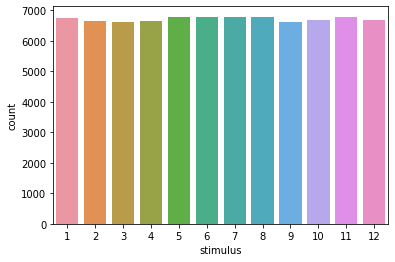

In [ ]:
sns.countplot(x = 'stimulus', data=df)
y.value_counts()

---
Fixing Data Imbalance via Undersampling

<Axes: xlabel='stimulus'>

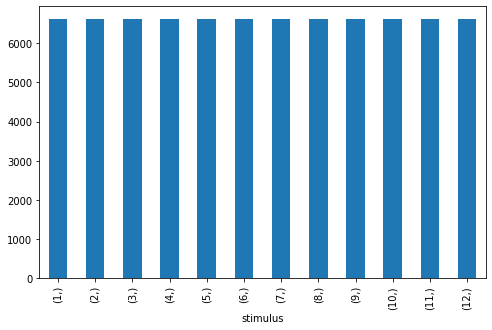

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = "not minority"
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(X, y)
y_res.value_counts().plot(kind='bar', figsize=(8,5))

In [ ]:
print(y_res.value_counts())
print(len(X_res.value_counts()))

stimulus
1           6613
2           6613
3           6613
4           6613
5           6613
6           6613
7           6613
8           6613
9           6613
10          6613
11          6613
12          6613
dtype: int64
79356


In [ ]:
print(y)

        stimulus
767            1
768            1
769            1
770            1
771            1
...          ...
130195        12
130196        12
130197        12
130198        12
130199        12

[80601 rows x 1 columns]


---
Visualization of Data Distributions

In [ ]:
# #distribution of first 19 features


# fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(40, 40))
# axs = axs.flatten()
# index = 0
# for k, v in df.items():
#   print(f"[{index +1}] Updating plot")
#   sns.distplot(v, ax=axs[index])
#   index += 1
#   if index == 20:
#     break 
# plt.tight_layout()

---
Defining Hyperparmaeters

In [ ]:
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

#Hyperparameters
emg_channels = 16
imu_channels = 3

latent_dim = 2
input_dim= len(X.columns)

hidden_dim= round(input_dim/2)
hidden_dim_2 = round(input_dim/4)
output_dim = len(X.columns)
num_classes = 12
num_layers = round(num_classes/2)
tempature = 1

num_epochs= 10
batch_size= 100
learning_rate= 0.001 #3e-4 #Karpathy constant
l2_lambda = 0


alpha = 2        # Reconstruction Loss
beta = 2         # Kl Divergence Loss
gamma = 3        # Classifcation Loss
delta = 5        # Contrastive Loss
epsilon = 3      # Triplet Loss

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

---
Train Test Split

In [ ]:
X = X_res.values
y = y_res.values
print(X.shape, type(X), y.shape, type(y))
print()

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(f"X_train size: {len(X_train)} | X_val size: {len(X_val)} | X_test size: {len(X_test)}")
print(f"y_train size: {len(y_train)} | y_val size: {len(y_val)} | y_test size: {len(y_test)}")
print()
print(f"Training Feature Split: {X_train.shape} | Training Labels { y_train.shape}")
print(f"Validation Feature Split: {X_val.shape} | Validation Labels { y_val.shape}")
print(f"Testing Feature Split: {X_test.shape} | Testing Labels { y_test.shape}")
print()

(79356, 41) <class 'numpy.ndarray'> (79356, 1) <class 'numpy.ndarray'>

X_train size: 47613 | X_val size: 15871 | X_test size: 15872
y_train size: 47613 | y_val size: 15871 | y_test size: 15872

Training Feature Split: (47613, 41) | Training Labels (47613, 1)
Validation Feature Split: (15871, 41) | Validation Labels (15871, 1)
Testing Feature Split: (15872, 41) | Testing Labels (15872, 1)



---
Scaling/Normalizing Data

In [ ]:
#Normalization Data 

#No Normalization 
# X_train_Normalized = X_train
# X_val_Normalized = X_val
# X_test_Normalized = X_test
#----------------------------------------------------------------------------------------------------------
# Minmax without preprocessing
# Minmax = preprocessing.MinMaxScaler()
# X_train_Normalized= Minmax.fit_transform(X_train)
# X_val_Normalized = Minmax.transform(X_val)
# X_test_Normalized = Minmax.transform(X_test)
#----------------------------------------------------------------------------------------------------------
# Minmax with preprocessing
# Minmax = preprocessing.MinMaxScaler()
# X_train_Normalized= Minmax.fit_transform(X_train_preprocessed)
# X_val_Normalized = Minmax.transform(X_val_preprocessed)
# X_test_Normalized = Minmax.transform(X_test_preprocessed)

#----------------------------------------------------------------------------------------------------------
# # Standardization without preprocessing
Standardized = preprocessing.StandardScaler()
X_train_Normalized= Standardized.fit_transform(X_train)
X_val_Normalized = Standardized.transform(X_val)
X_test_Normalized = Standardized.transform(X_test)

# Standardization with preprocessing
# Standardized = preprocessing.StandardScaler()
# X_train_Normalized= Standardized.fit_transform(X_train_preprocessed)
# X_val_Normalized = Standardized.transform(X_val_preprocessed)
# X_test_Normalized = Standardized.transform(X_test_preprocessed)
#----------------------------------------------------------------------------------------------------------

#Convert to numpy then to torch 

X_train = torch.from_numpy(X_train_Normalized).float()
y_train = torch.from_numpy(y_train).long()

X_val = torch.from_numpy(X_val_Normalized).float()
y_val = torch.from_numpy(y_val).long()

X_test = torch.from_numpy(X_test_Normalized).float()
y_test = torch.from_numpy(y_test).long()

print(f"X_train: {type(X_train)} | y_train {type(y_train)}")
print(f"X_val: {type(X_val)} | y_train {type(y_val)}")
print(f"X_test: {type(X_test)} | y_test {type(y_test)}")
print()
print(f"Training: {X_train.shape} , { y_train.shape}")
print(f"Validation: {X_val.shape} , { y_val.shape}")
print(f"Testing:  {X_test.shape} , { y_test.shape}")

X_train: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_val: <class 'torch.Tensor'> | y_train <class 'torch.Tensor'>
X_test: <class 'torch.Tensor'> | y_test <class 'torch.Tensor'>

Training: torch.Size([47613, 41]) , torch.Size([47613, 1])
Validation: torch.Size([15871, 41]) , torch.Size([15871, 1])
Testing:  torch.Size([15872, 41]) , torch.Size([15872, 1])


---
Defining Dataloaders


In [ ]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)

In [ ]:
training = ClassifierDataset(X_train, y_train)
validating = ClassifierDataset(X_val, y_val)
testing = ClassifierDataset(X_test, y_test)


train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validating, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)

def get_data_loader(optuna_batch_size):
  train_loader = DataLoader(training, batch_size=optuna_batch_size, shuffle=True)
  val_loader = DataLoader(validating, batch_size=optuna_batch_size, shuffle=False)
  test_loader = DataLoader(testing, batch_size=optuna_batch_size, shuffle=False)
  return train_loader, val_loader, test_loader

---
Defining VAE Model, Loss and Optmizers

In [ ]:
class VAE(nn.Module):  
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(VAE,self).__init__()  
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
    )
    self.mu = nn.Linear(hidden_dim_2, latent_dim)   # mu
    self.logvar = nn.Linear(hidden_dim_2, latent_dim)   # log-var
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim_2),
        nn.ReLU(),
        nn.Linear(hidden_dim_2, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
    )
    self.classifier = nn.Sequential(
        nn.Linear(latent_dim, num_layers),
        nn.ReLU(),
        nn.Linear(num_layers, 13),
        nn.Softmax(dim=1)
    )

  def encode(self, x):  
    z = self.encoder(x)
    z1 = self.mu(z)               
    z2 = self.logvar(z) 
    return z1, z2                 # (mu, log-var)

  def decode(self, x):

    return self.decoder(x)

  def forward(self, x):
#  Reparamaterize
    mu, logvar = self.encode(x)
    stdev = torch.exp(0.5 * logvar)
    esp = torch.randn_like(stdev)
    z_reparmeterized = mu + (esp * stdev)   

    x_reconstructed = self.decode(z_reparmeterized)
    classified = self.classifier(z_reparmeterized)
    classified = classified / tempature

    return (x_reconstructed, z_reparmeterized, classified, mu, logvar)

if __name__ == "__main__":
  x = torch.rand(batch_size,input_dim)
  vae = VAE(input_dim, hidden_dim, latent_dim)
  x_reconstructed, z_reparmeterized, classified, mu, logvar = vae(x)
  print(f"Reconstruction X: {x_reconstructed.shape}")

  print(f"Mu: {mu.shape} ")
  
  print(f"Logvar: {logvar.shape}")
 
  print(f"Latent Space Z: {z_reparmeterized.shape}")
 
  print(f"Classifier: {classified.shape}")

Reconstruction X: torch.Size([100, 41])
Mu: torch.Size([100, 2]) 
Logvar: torch.Size([100, 2])
Latent Space Z: torch.Size([100, 2])
Classifier: torch.Size([100, 13])


In [ ]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
        
  def forward(self, z_reparmeterized, labels):
    # Compute the pairwise euclidean distances between the examples in the latent space
    distances = torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True) + torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True).t() - 2 * torch.matmul(z_reparmeterized, z_reparmeterized.t())
    # Create a mask for the positive pairs (i.e. examples with the same label)
    positive_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).eq(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Create a mask for the negative pairs (i.e. examples with different labels)
    negative_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).ne(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Set the distances for the positive pairs to a large value
    distances.masked_fill_(positive_mask, 1e7)
    # Compute the contrastive loss as the sum of the max(0, margin - distance) for the negative pairs
    contrastive_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances))
    return contrastive_loss

In [ ]:
def train_VAE(trial, model, train_loader, val_loader, optimizer, epoch,alpha,beta,gamma, delta):
  train_losses=[]
  train_accuracy = []
  accuracy_log = []
  val_losses=[]
  val_accuracy=[]

  recon_loss_fn = nn.MSELoss(reduction="sum")
  classifier_loss_fn = nn.CrossEntropyLoss()
  contrastive_loss_fn = ContrastiveLoss(margin=1)

  train_running_loss = 0
  model.train()
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    # print(f"Input shape: {inputs.shape}")
    # print(f"Labels shape: {labels.shape}")
    optimizer.zero_grad()
    
    x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)

    # Compute the reconstruction loss and KL divergence loss #################################################

    reconstruction_loss = recon_loss_fn(x_reconstructed, inputs)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    contrastive_loss = contrastive_loss_fn(mu, labels)

    # Compute the classificaiton loss #########################################################################
    classified = classified.view(-1, 13)
    classification_loss = classifier_loss_fn(classified, labels.flatten())

  
    loss = (alpha*reconstruction_loss + kld_loss*beta) + gamma*classification_loss + (delta*contrastive_loss)

    accuracy = accuracy_score(labels, classified.argmax(dim=1))
    train_accuracy.append(accuracy)
    train_acc = sum(train_accuracy)/len(train_accuracy)
    accuracy_log.append(train_acc)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
    train_loss= train_running_loss/len(train_loader)

  with torch.inference_mode():
    val_running_loss = 0
    val_running_acc = 0

    model.eval()
    # Iterate over the validation data
    for X, Y in val_loader:
      # Pass the data through the model and get the reconstructed data and the latent representation
      y_pred, z_reparmeterized, v_classified, mu, logvar = model(X)

      # Compute the reconstruction loss
      v_reconstruction_loss = recon_loss_fn(y_pred, X)

      # Compute the KL divergence loss
      v_kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

      v_contrastive_loss_value = contrastive_loss_fn(mu, Y)

      # Reshape the classified output to have the same shape as the labels
      v_classified = v_classified.view(-1, 13)
      # Compute the classification loss
      v_classification_loss = classifier_loss_fn(v_classified, Y.flatten())

      # Compute the total loss
      vloss = (alpha*v_reconstruction_loss + v_kld_loss*beta) + gamma*v_classification_loss + delta*v_contrastive_loss_value
      val_running_loss += vloss.item()
      val_loss = val_running_loss/len(val_loader)

      v_accuracy = accuracy_score(Y, v_classified.argmax(dim=1))
      val_accuracy.append(v_accuracy)
      val_acc = sum(val_accuracy)/len(val_accuracy)

  print(f"Epoch: {epoch+1} / {num_epochs} | Reconst_loss: {reconstruction_loss:.3f} | Kldiv loss: {kld_loss:.3f} | Classifcation loss: {classification_loss:.3f} | Constrast loss: {contrastive_loss:.2f} | Total loss: {train_loss:.3f} | Train acc: {train_acc*100:.3f} % ||| Val Loss: {val_loss:.3f} | Val acc: {val_acc*100:.3f} %")
  print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  trial.report(train_acc, epoch)
  if trial.should_prune():
      raise optuna.TrialPruned()

  return train_losses, val_losses, train_acc, val_acc



In [ ]:
def objective(trial):
  params = {
          'optuna_batch_size' : trial.suggest_int('optuna_batch_size', 1e2, 1e3),
          'num_epochs' : num_epochs,
          'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop"]),
          "lr": trial.suggest_float('lr', 1e-4, 1e-2),
          "hidden_dim": trial.suggest_int('hidden_dim', 1e2, 1e3),
          'alpha': trial.suggest_int('alpha', 1e-1, 1e1),
          'beta': trial.suggest_int('beta', 1e-1, 1e1), 
          'gamma': trial.suggest_int('gamma', 1e-1, 1e1), 
          'delta': trial.suggest_int('delta', 1e-1, 1e1),        
  }

  train_loader, val_loader, test_loader = get_data_loader(params['optuna_batch_size'])
  model  = VAE(input_dim, params['hidden_dim'], latent_dim).to(device)
  optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['lr'])

  for epoch in range(params['num_epochs']):
    train_losses, val_losses, train_acc, val_acc = train_VAE(trial, model, train_loader, val_loader, optimizer, epoch, alpha, beta, gamma, delta)
  return train_acc


In [22]:
sampler = optuna.samplers.TPESampler()    
study = optuna.create_study(
    sampler=sampler,
    pruner=ThresholdPruner(lower=0.3, n_warmup_steps=3, interval_steps=1),
    direction='maximize')
study.optimize(func=objective, n_trials=200)

[I 2023-03-17 20:27:26,506] A new study created in memory with name: no-name-8ca5838a-a51e-4f92-a5a3-ceebe396031a


Epoch: 1 / 10 | Reconst_loss: 14791.948 | Kldiv loss: 7426.449 | Classifcation loss: 2.487 | Constrast loss: 2257.91 | Total loss: 96818426.901 | Train acc: 13.534 % ||| Val Loss: 109402.027 | Val acc: 16.324 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 15392.527 | Kldiv loss: 6219.307 | Classifcation loss: 2.443 | Constrast loss: 1377.13 | Total loss: 97190.654 | Train acc: 16.776 % ||| Val Loss: 86853.628 | Val acc: 17.826 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 3 / 10 | Reconst_loss: 12912.701 | Kldiv loss: 4400.440 | Classifcation loss: 2.384 | Constrast loss: 1124.58 | Total loss: 78692.824 | Train acc: 25.947 % ||| Val Loss: 70395.951 | Val acc: 34.757 %
-----------

[I 2023-03-17 20:32:12,210] Trial 0 finished with value: 0.6041932720322027 and parameters: {'optuna_batch_size': 726, 'optimizer': 'Adam', 'lr': 0.004051849855739276, 'hidden_dim': 857, 'alpha': 4, 'beta': 10, 'gamma': 6, 'delta': 0}. Best is trial 0 with value: 0.6041932720322027.


Epoch: 10 / 10 | Reconst_loss: 9769.335 | Kldiv loss: 3680.631 | Classifcation loss: 2.131 | Constrast loss: 292.95 | Total loss: 49742.079 | Train acc: 60.419 % ||| Val Loss: 48360.979 | Val acc: 60.240 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.138 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------

[I 2023-03-17 20:33:41,262] Trial 1 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 7033.657 | Kldiv loss: 3168.535 | Classifcation loss: 2.536 | Constrast loss: 249.50 | Total loss: 314862.982 | Train acc: 11.317 % ||| Val Loss: 112929.708 | Val acc: 14.262 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 7286.917 | Kldiv loss: 2848.901 | Classifcation loss: 2.514 | Constrast loss: 182.84 | Total loss: 109950.324 | Train acc: 19.632 % ||| Val Loss: 100389.006 | Val acc: 21.825 %
----------------------------------------------

[I 2023-03-17 20:34:26,680] Trial 2 pruned. 


Epoch: 4 / 10 | Reconst_loss: 6388.633 | Kldiv loss: 1958.827 | Classifcation loss: 2.420 | Constrast loss: 201.83 | Total loss: 89175.721 | Train acc: 28.298 % ||| Val Loss: 81536.252 | Val acc: 30.435 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 19813.043 | Kldiv loss: 18706.111 | Classifcation loss: 2.454 | Constrast loss: 4907.96 | Total loss: 644884.635 | Train acc: 15.250 % ||| Val Loss: 132601.100 | Val acc: 17.771 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 21151.066 | Kldiv loss: 9021.927 | Classifcation loss: 2.438 | Constrast loss: 3103.69 | Total loss: 108664.077 | Train acc: 21.996 % ||| Val Loss: 91965.938 | Val acc: 23.318 %
-------------

[I 2023-03-17 20:34:52,676] Trial 3 finished with value: 0.678854983701249 and parameters: {'optuna_batch_size': 796, 'optimizer': 'Adam', 'lr': 0.002722277025487078, 'hidden_dim': 159, 'alpha': 2, 'beta': 0, 'gamma': 1, 'delta': 7}. Best is trial 3 with value: 0.678854983701249.


Epoch: 10 / 10 | Reconst_loss: 15031.694 | Kldiv loss: 4794.913 | Classifcation loss: 2.060 | Constrast loss: 643.77 | Total loss: 54346.362 | Train acc: 67.885 % ||| Val Loss: 53154.287 | Val acc: 68.996 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5161.558 | Kldiv loss: 1007.842 | Classifcation loss: 2.474 | Constrast loss: 232.79 | Total loss: 24612.604 | Train acc: 19.288 % ||| Val Loss: 17952.406 | Val acc: 25.104 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4071.103 | Kldiv loss: 971.590 | Classifcation loss: 2.452 | Constrast loss: 145.43 | Total loss: 17103.144 | Train acc: 28.351 % ||| Val Loss: 15271.483 | Val acc: 29.521 %
--------------------

[I 2023-03-17 20:35:52,188] Trial 4 finished with value: 0.6067314502893681 and parameters: {'optuna_batch_size': 227, 'optimizer': 'RMSprop', 'lr': 0.0007578141392989757, 'hidden_dim': 294, 'alpha': 7, 'beta': 3, 'gamma': 0, 'delta': 5}. Best is trial 3 with value: 0.678854983701249.


Epoch: 10 / 10 | Reconst_loss: 3302.541 | Kldiv loss: 967.478 | Classifcation loss: 2.145 | Constrast loss: 44.15 | Total loss: 12795.084 | Train acc: 60.673 % ||| Val Loss: 12192.951 | Val acc: 61.976 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3357.783 | Kldiv loss: 984.244 | Classifcation loss: 2.396 | Constrast loss: 168.08 | Total loss: 9663093886.314 | Train acc: 16.085 % ||| Val Loss: 38230.920 | Val acc: 31.519 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3279.798 | Kldiv loss: 866.755 | Classifcation loss: 2.227 | Constrast loss: 53.23 | Total loss: 34753.718 | Train acc: 44.057 % ||| Val Loss: 30909.808 | Val acc: 51.166 %
--------------------

[I 2023-03-17 20:39:09,837] Trial 5 finished with value: 0.8164077422695987 and parameters: {'optuna_batch_size': 383, 'optimizer': 'Adam', 'lr': 0.00818175550348311, 'hidden_dim': 696, 'alpha': 8, 'beta': 1, 'gamma': 9, 'delta': 7}. Best is trial 5 with value: 0.8164077422695987.


Epoch: 10 / 10 | Reconst_loss: 2917.777 | Kldiv loss: 794.277 | Classifcation loss: 1.817 | Constrast loss: 8.68 | Total loss: 23157.441 | Train acc: 81.641 % ||| Val Loss: 22915.417 | Val acc: 81.768 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.077 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
---------------------------------------------------------------------------------

[I 2023-03-17 20:41:07,431] Trial 6 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.079 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------------------------------

[I 2023-03-17 20:41:39,323] Trial 7 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 8281.028 | Kldiv loss: 2659.055 | Classifcation loss: 2.392 | Constrast loss: 380.56 | Total loss: 54828.143 | Train acc: 18.304 % ||| Val Loss: 29604.016 | Val acc: 36.154 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 7316.409 | Kldiv loss: 2478.399 | Classifcation loss: 2.198 | Constrast loss: 282.98 | Total loss: 28086.705 | Train acc: 48.256 % ||| Val Loss: 25594.866 | Val acc: 59.502 %
--------------------------------------------------

[I 2023-03-17 20:43:46,309] Trial 8 finished with value: 0.6915694063825122 and parameters: {'optuna_batch_size': 394, 'optimizer': 'Adam', 'lr': 0.009529509832233206, 'hidden_dim': 529, 'alpha': 1, 'beta': 0, 'gamma': 3, 'delta': 2}. Best is trial 5 with value: 0.8164077422695987.


Epoch: 10 / 10 | Reconst_loss: 7003.203 | Kldiv loss: 2047.427 | Classifcation loss: 1.964 | Constrast loss: 94.39 | Total loss: 23631.183 | Train acc: 69.157 % ||| Val Loss: 21658.637 | Val acc: 70.075 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1042.160 | Kldiv loss: 332.237 | Classifcation loss: 2.530 | Constrast loss: 12.04 | Total loss: 296463418116020608.000 | Train acc: 16.204 % ||| Val Loss: 28941.349 | Val acc: 19.618 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1421.731 | Kldiv loss: 275.930 | Classifcation loss: 2.346 | Constrast loss: 15.82 | Total loss: 26541.709 | Train acc: 24.689 % ||| Val Loss: 24902.804 | Val acc: 27.880 %
------------

[I 2023-03-17 20:45:40,333] Trial 9 finished with value: 0.6877269977451463 and parameters: {'optuna_batch_size': 275, 'optimizer': 'RMSprop', 'lr': 0.0014917195336417526, 'hidden_dim': 479, 'alpha': 4, 'beta': 4, 'gamma': 9, 'delta': 9}. Best is trial 5 with value: 0.8164077422695987.


Epoch: 10 / 10 | Reconst_loss: 1079.972 | Kldiv loss: 224.441 | Classifcation loss: 2.159 | Constrast loss: 4.57 | Total loss: 17756.302 | Train acc: 68.773 % ||| Val Loss: 22813.068 | Val acc: 48.206 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 967.345 | Kldiv loss: 238.739 | Classifcation loss: 2.129 | Constrast loss: 19.94 | Total loss: 9882.876 | Train acc: 42.233 % ||| Val Loss: 7108.229 | Val acc: 64.328 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1591.105 | Kldiv loss: 293.554 | Classifcation loss: 1.988 | Constrast loss: 15.93 | Total loss: 6990.317 | Train acc: 66.847 % ||| Val Loss: 7406.311 | Val acc: 62.449 %
--------------------------------

[I 2023-03-17 20:49:55,069] Trial 10 finished with value: 0.7145571443723105 and parameters: {'optuna_batch_size': 116, 'optimizer': 'Adam', 'lr': 0.005503001381885199, 'hidden_dim': 694, 'alpha': 10, 'beta': 7, 'gamma': 10, 'delta': 8}. Best is trial 5 with value: 0.8164077422695987.


Epoch: 10 / 10 | Reconst_loss: 1262.658 | Kldiv loss: 322.804 | Classifcation loss: 2.077 | Constrast loss: 16.99 | Total loss: 6215.072 | Train acc: 71.456 % ||| Val Loss: 6570.393 | Val acc: 70.116 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 479.465 | Kldiv loss: 104.633 | Classifcation loss: 1.968 | Constrast loss: 0.00 | Total loss: 8152.083 | Train acc: 50.525 % ||| Val Loss: 7166.159 | Val acc: 67.494 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 377.524 | Kldiv loss: 66.849 | Classifcation loss: 1.944 | Constrast loss: 5.66 | Total loss: 6286.269 | Train acc: 79.945 % ||| Val Loss: 6129.539 | Val acc: 84.941 %
-------------------------------------

[I 2023-03-17 20:54:20,756] Trial 11 finished with value: 0.928888888888889 and parameters: {'optuna_batch_size': 106, 'optimizer': 'Adam', 'lr': 0.005897994275222237, 'hidden_dim': 705, 'alpha': 10, 'beta': 6, 'gamma': 10, 'delta': 8}. Best is trial 11 with value: 0.928888888888889.


Epoch: 10 / 10 | Reconst_loss: 532.419 | Kldiv loss: 113.289 | Classifcation loss: 1.694 | Constrast loss: 0.00 | Total loss: 5586.664 | Train acc: 92.889 % ||| Val Loss: 5325.779 | Val acc: 93.212 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 16759.627 | Kldiv loss: 10821.368 | Classifcation loss: 2.483 | Constrast loss: 3855.91 | Total loss: 247543.656 | Train acc: 13.362 % ||| Val Loss: 75826.596 | Val acc: 17.615 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 16021.497 | Kldiv loss: 6074.646 | Classifcation loss: 2.352 | Constrast loss: 1392.49 | Total loss: 60557.781 | Train acc: 29.543 % ||| Val Loss: 49836.736 | Val acc: 36.401 %
--------------------

[I 2023-03-17 21:00:29,907] Trial 12 finished with value: 0.6470505002306062 and parameters: {'optuna_batch_size': 535, 'optimizer': 'Adam', 'lr': 0.005678659077869902, 'hidden_dim': 990, 'alpha': 10, 'beta': 6, 'gamma': 8, 'delta': 3}. Best is trial 11 with value: 0.928888888888889.


Epoch: 10 / 10 | Reconst_loss: 10670.260 | Kldiv loss: 3597.221 | Classifcation loss: 2.048 | Constrast loss: 391.23 | Total loss: 32906.841 | Train acc: 64.705 % ||| Val Loss: 31750.853 | Val acc: 63.418 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 686.995 | Kldiv loss: 198.429 | Classifcation loss: 2.152 | Constrast loss: 4.34 | Total loss: 13410.805 | Train acc: 47.260 % ||| Val Loss: 9580.936 | Val acc: 73.183 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1062.708 | Kldiv loss: 201.707 | Classifcation loss: 1.814 | Constrast loss: 3.27 | Total loss: 9018.081 | Train acc: 82.942 % ||| Val Loss: 8710.493 | Val acc: 89.246 %
-----------------------------

[I 2023-03-17 21:03:53,023] Trial 13 finished with value: 0.9585126527801691 and parameters: {'optuna_batch_size': 152, 'optimizer': 'Adam', 'lr': 0.009656988494695613, 'hidden_dim': 656, 'alpha': 10, 'beta': 7, 'gamma': 7, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1006.006 | Kldiv loss: 201.993 | Classifcation loss: 1.719 | Constrast loss: 0.30 | Total loss: 8152.537 | Train acc: 95.851 % ||| Val Loss: 8062.482 | Val acc: 95.743 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 964.369 | Kldiv loss: 241.978 | Classifcation loss: 2.093 | Constrast loss: 7.44 | Total loss: 11982.219 | Train acc: 42.614 % ||| Val Loss: 8521.008 | Val acc: 62.507 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1214.309 | Kldiv loss: 253.061 | Classifcation loss: 2.027 | Constrast loss: 9.69 | Total loss: 8469.076 | Train acc: 70.053 % ||| Val Loss: 8973.643 | Val acc: 68.411 %
-----------------------------------

[I 2023-03-17 21:07:20,177] Trial 14 finished with value: 0.7635766147271225 and parameters: {'optuna_batch_size': 142, 'optimizer': 'Adam', 'lr': 0.009746567407136295, 'hidden_dim': 633, 'alpha': 10, 'beta': 8, 'gamma': 7, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 598.664 | Kldiv loss: 223.253 | Classifcation loss: 2.022 | Constrast loss: 9.52 | Total loss: 7637.586 | Train acc: 76.358 % ||| Val Loss: 7567.691 | Val acc: 74.332 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 272.517 | Kldiv loss: 89.477 | Classifcation loss: 1.998 | Constrast loss: 0.00 | Total loss: 13474.224 | Train acc: 39.108 % ||| Val Loss: 6515.102 | Val acc: 69.239 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 153.266 | Kldiv loss: 86.008 | Classifcation loss: 1.940 | Constrast loss: 0.00 | Total loss: 5941.598 | Train acc: 73.956 % ||| Val Loss: 5701.541 | Val acc: 77.370 %
---------------------------------------

[I 2023-03-17 21:13:07,843] Trial 15 finished with value: 0.8408514755684564 and parameters: {'optuna_batch_size': 100, 'optimizer': 'Adam', 'lr': 0.004282083280330081, 'hidden_dim': 823, 'alpha': 5, 'beta': 5, 'gamma': 6, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 262.040 | Kldiv loss: 72.784 | Classifcation loss: 1.843 | Constrast loss: 0.00 | Total loss: 5075.509 | Train acc: 84.085 % ||| Val Loss: 5025.970 | Val acc: 83.812 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4284.016 | Kldiv loss: 1406.654 | Classifcation loss: 2.421 | Constrast loss: 155.73 | Total loss: 789850.079 | Train acc: 14.477 % ||| Val Loss: 43850.192 | Val acc: 23.652 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3899.487 | Kldiv loss: 1179.110 | Classifcation loss: 2.300 | Constrast loss: 99.50 | Total loss: 39922.616 | Train acc: 35.937 % ||| Val Loss: 35504.693 | Val acc: 43.451 %
---------------------------

[I 2023-03-17 21:19:25,906] Trial 16 finished with value: 0.5767745722115528 and parameters: {'optuna_batch_size': 383, 'optimizer': 'Adam', 'lr': 0.006272127124625823, 'hidden_dim': 994, 'alpha': 9, 'beta': 8, 'gamma': 10, 'delta': 8}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 3085.194 | Kldiv loss: 778.117 | Classifcation loss: 2.187 | Constrast loss: 12.93 | Total loss: 23812.488 | Train acc: 57.677 % ||| Val Loss: 23269.449 | Val acc: 57.971 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2640.789 | Kldiv loss: 544.188 | Classifcation loss: 2.106 | Constrast loss: 43.08 | Total loss: 25926.245 | Train acc: 37.738 % ||| Val Loss: 13787.567 | Val acc: 71.326 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1917.166 | Kldiv loss: 485.533 | Classifcation loss: 1.879 | Constrast loss: 26.41 | Total loss: 13641.604 | Train acc: 78.096 % ||| Val Loss: 12475.336 | Val acc: 82.486 %
--------------------------

[I 2023-03-17 21:21:02,424] Trial 17 finished with value: 0.8950788995950307 and parameters: {'optuna_batch_size': 217, 'optimizer': 'Adam', 'lr': 0.008035534760574907, 'hidden_dim': 409, 'alpha': 6, 'beta': 6, 'gamma': 8, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2042.927 | Kldiv loss: 501.179 | Classifcation loss: 1.809 | Constrast loss: 5.78 | Total loss: 11671.198 | Train acc: 89.508 % ||| Val Loss: 11476.931 | Val acc: 88.820 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 14860.459 | Kldiv loss: 6285.234 | Classifcation loss: 2.487 | Constrast loss: 1779.16 | Total loss: 175023.006 | Train acc: 14.064 % ||| Val Loss: 65315.283 | Val acc: 16.109 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 13241.406 | Kldiv loss: 4649.430 | Classifcation loss: 2.320 | Constrast loss: 804.70 | Total loss: 57068.560 | Train acc: 26.373 % ||| Val Loss: 47739.464 | Val acc: 38.989 %
-------------------

[I 2023-03-17 21:23:33,083] Trial 18 finished with value: 0.6954910281708364 and parameters: {'optuna_batch_size': 604, 'optimizer': 'Adam', 'lr': 0.004706753575347085, 'hidden_dim': 616, 'alpha': 9, 'beta': 8, 'gamma': 5, 'delta': 8}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 9770.411 | Kldiv loss: 2861.777 | Classifcation loss: 2.069 | Constrast loss: 241.23 | Total loss: 33470.738 | Train acc: 69.549 % ||| Val Loss: 31967.777 | Val acc: 68.558 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 7926.398 | Kldiv loss: 1445.749 | Classifcation loss: 2.247 | Constrast loss: 198.30 | Total loss: 46326.675 | Train acc: 27.524 % ||| Val Loss: 25927.779 | Val acc: 47.088 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5881.488 | Kldiv loss: 1359.904 | Classifcation loss: 2.130 | Constrast loss: 105.83 | Total loss: 22861.243 | Train acc: 53.361 % ||| Val Loss: 20190.499 | Val acc: 55.309 %
--------------------

[I 2023-03-17 21:26:12,847] Trial 19 finished with value: 0.6380783782529112 and parameters: {'optuna_batch_size': 320, 'optimizer': 'Adam', 'lr': 0.009920943380370216, 'hidden_dim': 604, 'alpha': 3, 'beta': 5, 'gamma': 7, 'delta': 3}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 5726.711 | Kldiv loss: 1449.066 | Classifcation loss: 2.067 | Constrast loss: 108.21 | Total loss: 18817.955 | Train acc: 63.808 % ||| Val Loss: 17502.189 | Val acc: 64.529 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4103.410 | Kldiv loss: 851.773 | Classifcation loss: 2.172 | Constrast loss: 94.47 | Total loss: 16930.204 | Train acc: 37.634 % ||| Val Loss: 11818.209 | Val acc: 66.445 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3972.530 | Kldiv loss: 785.981 | Classifcation loss: 1.964 | Constrast loss: 85.82 | Total loss: 10849.254 | Train acc: 77.851 % ||| Val Loss: 10199.918 | Val acc: 82.204 %
------------------------

[I 2023-03-17 21:30:33,968] Trial 20 finished with value: 0.9269494912325499 and parameters: {'optuna_batch_size': 172, 'optimizer': 'Adam', 'lr': 0.007346076126315902, 'hidden_dim': 758, 'alpha': 0, 'beta': 7, 'gamma': 3, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2852.002 | Kldiv loss: 727.732 | Classifcation loss: 1.771 | Constrast loss: 40.30 | Total loss: 9010.900 | Train acc: 92.695 % ||| Val Loss: 9110.304 | Val acc: 90.600 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4903.263 | Kldiv loss: 1200.305 | Classifcation loss: 2.192 | Constrast loss: 91.31 | Total loss: 18647.273 | Train acc: 38.493 % ||| Val Loss: 12408.980 | Val acc: 63.094 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4347.584 | Kldiv loss: 1007.404 | Classifcation loss: 1.982 | Constrast loss: 64.63 | Total loss: 11851.017 | Train acc: 66.654 % ||| Val Loss: 11026.467 | Val acc: 68.644 %
--------------------------

[I 2023-03-17 21:34:36,218] Trial 21 finished with value: 0.8092450688236134 and parameters: {'optuna_batch_size': 189, 'optimizer': 'Adam', 'lr': 0.007367026524391258, 'hidden_dim': 752, 'alpha': 0, 'beta': 7, 'gamma': 3, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 3040.052 | Kldiv loss: 945.359 | Classifcation loss: 1.910 | Constrast loss: 12.99 | Total loss: 9875.961 | Train acc: 80.925 % ||| Val Loss: 9729.980 | Val acc: 80.819 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1158.511 | Kldiv loss: 231.062 | Classifcation loss: 2.028 | Constrast loss: 6.75 | Total loss: 15685.646 | Train acc: 42.473 % ||| Val Loss: 12413.341 | Val acc: 56.895 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1244.141 | Kldiv loss: 181.929 | Classifcation loss: 2.124 | Constrast loss: 1.80 | Total loss: 10753.779 | Train acc: 61.161 % ||| Val Loss: 10096.196 | Val acc: 62.695 %
------------------------------

[I 2023-03-17 21:40:14,617] Trial 22 finished with value: 0.7250455240891877 and parameters: {'optuna_batch_size': 173, 'optimizer': 'Adam', 'lr': 0.008854572484634745, 'hidden_dim': 896, 'alpha': 0, 'beta': 7, 'gamma': 2, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 726.520 | Kldiv loss: 192.229 | Classifcation loss: 1.951 | Constrast loss: 0.61 | Total loss: 9237.901 | Train acc: 72.505 % ||| Val Loss: 9032.565 | Val acc: 73.314 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 232.011 | Kldiv loss: 81.370 | Classifcation loss: 2.281 | Constrast loss: 5.26 | Total loss: 54040.748 | Train acc: 23.451 % ||| Val Loss: 21861.908 | Val acc: 43.499 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 278.573 | Kldiv loss: 80.117 | Classifcation loss: 1.971 | Constrast loss: 0.18 | Total loss: 18993.802 | Train acc: 58.445 % ||| Val Loss: 17587.786 | Val acc: 65.059 %
------------------------------------

[I 2023-03-17 21:43:45,322] Trial 23 finished with value: 0.851016342053026 and parameters: {'optuna_batch_size': 292, 'optimizer': 'Adam', 'lr': 0.006405695529224112, 'hidden_dim': 701, 'alpha': 2, 'beta': 6, 'gamma': 4, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 288.906 | Kldiv loss: 95.623 | Classifcation loss: 1.874 | Constrast loss: 0.00 | Total loss: 15357.640 | Train acc: 85.102 % ||| Val Loss: 15807.526 | Val acc: 84.104 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2711.100 | Kldiv loss: 2024.238 | Classifcation loss: 2.427 | Constrast loss: 378.62 | Total loss: 270816.910 | Train acc: 15.615 % ||| Val Loss: 111386.640 | Val acc: 25.139 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3031.917 | Kldiv loss: 2039.525 | Classifcation loss: 2.449 | Constrast loss: 307.52 | Total loss: 101001.127 | Train acc: 30.236 % ||| Val Loss: 97153.302 | Val acc: 30.459 %
----------------------

[I 2023-03-17 21:47:44,906] Trial 24 finished with value: 0.5342073809830278 and parameters: {'optuna_batch_size': 457, 'optimizer': 'Adam', 'lr': 0.008956022648415723, 'hidden_dim': 766, 'alpha': 9, 'beta': 9, 'gamma': 5, 'delta': 7}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2571.707 | Kldiv loss: 1420.291 | Classifcation loss: 2.180 | Constrast loss: 67.64 | Total loss: 51538.060 | Train acc: 53.421 % ||| Val Loss: 49731.330 | Val acc: 54.228 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 15984.552 | Kldiv loss: 5480.967 | Classifcation loss: 2.464 | Constrast loss: 1190.73 | Total loss: 181489.538 | Train acc: 14.327 % ||| Val Loss: 68655.303 | Val acc: 26.582 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 12930.414 | Kldiv loss: 3816.604 | Classifcation loss: 2.326 | Constrast loss: 688.02 | Total loss: 62455.382 | Train acc: 32.227 % ||| Val Loss: 53289.197 | Val acc: 40.990 %
-----------------

[I 2023-03-17 21:53:09,348] Trial 25 finished with value: 0.6595338499787371 and parameters: {'optuna_batch_size': 629, 'optimizer': 'Adam', 'lr': 0.00749941948764706, 'hidden_dim': 922, 'alpha': 5, 'beta': 4, 'gamma': 2, 'delta': 8}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 9861.122 | Kldiv loss: 2657.099 | Classifcation loss: 2.069 | Constrast loss: 90.34 | Total loss: 38432.900 | Train acc: 65.953 % ||| Val Loss: 35775.941 | Val acc: 65.911 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 741.172 | Kldiv loss: 90.918 | Classifcation loss: 1.958 | Constrast loss: 0.00 | Total loss: 8360.920 | Train acc: 46.124 % ||| Val Loss: 6183.538 | Val acc: 67.023 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 237.331 | Kldiv loss: 63.707 | Classifcation loss: 1.937 | Constrast loss: 0.00 | Total loss: 6120.688 | Train acc: 66.939 % ||| Val Loss: 5769.401 | Val acc: 69.153 %
-----------------------------------

[I 2023-03-17 21:56:49,022] Trial 26 finished with value: 0.7228221254636349 and parameters: {'optuna_batch_size': 100, 'optimizer': 'Adam', 'lr': 0.007883624293384156, 'hidden_dim': 615, 'alpha': 10, 'beta': 9, 'gamma': 9, 'delta': 6}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 191.094 | Kldiv loss: 66.293 | Classifcation loss: 1.864 | Constrast loss: 2.40 | Total loss: 5294.265 | Train acc: 72.282 % ||| Val Loss: 5216.642 | Val acc: 71.742 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2090.786 | Kldiv loss: 494.907 | Classifcation loss: 2.085 | Constrast loss: 33.76 | Total loss: 26884.012 | Train acc: 34.618 % ||| Val Loss: 16261.555 | Val acc: 49.548 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2456.979 | Kldiv loss: 463.135 | Classifcation loss: 2.098 | Constrast loss: 30.46 | Total loss: 14737.547 | Train acc: 59.848 % ||| Val Loss: 14717.703 | Val acc: 55.359 %
-------------------------------

[I 2023-03-17 22:01:25,700] Trial 27 finished with value: 0.7252547517814623 and parameters: {'optuna_batch_size': 218, 'optimizer': 'Adam', 'lr': 0.00894841336784372, 'hidden_dim': 796, 'alpha': 6, 'beta': 5, 'gamma': 6, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1818.190 | Kldiv loss: 459.645 | Classifcation loss: 1.941 | Constrast loss: 29.27 | Total loss: 12104.037 | Train acc: 72.525 % ||| Val Loss: 13338.434 | Val acc: 70.299 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 8472.992 | Kldiv loss: 2207.210 | Classifcation loss: 2.315 | Constrast loss: 647.43 | Total loss: 112818.197 | Train acc: 21.148 % ||| Val Loss: 26806.516 | Val acc: 42.616 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 7429.760 | Kldiv loss: 2106.606 | Classifcation loss: 2.083 | Constrast loss: 328.82 | Total loss: 24553.121 | Train acc: 56.580 % ||| Val Loss: 21949.690 | Val acc: 63.894 %
---------------------

[I 2023-03-17 22:04:41,511] Trial 28 finished with value: 0.7395787642982596 and parameters: {'optuna_batch_size': 322, 'optimizer': 'Adam', 'lr': 0.006651385422265094, 'hidden_dim': 688, 'alpha': 3, 'beta': 7, 'gamma': 8, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 5553.173 | Kldiv loss: 1673.617 | Classifcation loss: 1.943 | Constrast loss: 135.41 | Total loss: 18344.567 | Train acc: 73.958 % ||| Val Loss: 17317.134 | Val acc: 74.545 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 17118.949 | Kldiv loss: 27172.977 | Classifcation loss: 2.517 | Constrast loss: 11145.42 | Total loss: 18997192767.036 | Train acc: 9.631 % ||| Val Loss: 338203.035 | Val acc: 14.117 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 16787.412 | Kldiv loss: 8316.520 | Classifcation loss: 2.468 | Constrast loss: 2003.54 | Total loss: 212137.004 | Train acc: 15.447 % ||| Val Loss: 121415.633 | Val acc: 17.374 %
------

[I 2023-03-17 22:09:50,057] Trial 29 finished with value: 0.7065651591096465 and parameters: {'optuna_batch_size': 873, 'optimizer': 'Adam', 'lr': 0.0058229563164784335, 'hidden_dim': 903, 'alpha': 4, 'beta': 6, 'gamma': 6, 'delta': 1}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 11524.407 | Kldiv loss: 4011.198 | Classifcation loss: 2.014 | Constrast loss: 463.62 | Total loss: 69532.198 | Train acc: 70.657 % ||| Val Loss: 65560.180 | Val acc: 70.433 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5584.519 | Kldiv loss: 1035.295 | Classifcation loss: 2.205 | Constrast loss: 174.87 | Total loss: 20327.566 | Train acc: 27.973 % ||| Val Loss: 13004.813 | Val acc: 51.527 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4006.115 | Kldiv loss: 961.240 | Classifcation loss: 2.029 | Constrast loss: 96.71 | Total loss: 12268.373 | Train acc: 64.235 % ||| Val Loss: 11276.175 | Val acc: 74.471 %
---------------------

[I 2023-03-17 22:12:29,335] Trial 30 finished with value: 0.8655823972734257 and parameters: {'optuna_batch_size': 192, 'optimizer': 'Adam', 'lr': 0.003473168184973162, 'hidden_dim': 576, 'alpha': 9, 'beta': 9, 'gamma': 4, 'delta': 5}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 3383.451 | Kldiv loss: 927.857 | Classifcation loss: 1.844 | Constrast loss: 36.70 | Total loss: 9943.738 | Train acc: 86.558 % ||| Val Loss: 9696.381 | Val acc: 85.927 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1361.179 | Kldiv loss: 367.532 | Classifcation loss: 2.262 | Constrast loss: 27.67 | Total loss: 34946.978 | Train acc: 26.228 % ||| Val Loss: 18289.577 | Val acc: 39.761 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1250.481 | Kldiv loss: 303.385 | Classifcation loss: 2.281 | Constrast loss: 14.31 | Total loss: 16889.849 | Train acc: 51.488 % ||| Val Loss: 17379.762 | Val acc: 57.627 %
----------------------------

[I 2023-03-17 22:14:00,342] Trial 31 finished with value: 0.7379051360928809 and parameters: {'optuna_batch_size': 232, 'optimizer': 'Adam', 'lr': 0.007692580192017772, 'hidden_dim': 416, 'alpha': 6, 'beta': 6, 'gamma': 8, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1238.823 | Kldiv loss: 317.001 | Classifcation loss: 1.995 | Constrast loss: 5.25 | Total loss: 13064.492 | Train acc: 73.791 % ||| Val Loss: 12707.081 | Val acc: 74.520 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4352.940 | Kldiv loss: 836.918 | Classifcation loss: 2.000 | Constrast loss: 103.99 | Total loss: 14315.502 | Train acc: 47.890 % ||| Val Loss: 9941.148 | Val acc: 81.784 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2780.765 | Kldiv loss: 743.765 | Classifcation loss: 1.880 | Constrast loss: 59.33 | Total loss: 9633.628 | Train acc: 79.709 % ||| Val Loss: 9112.092 | Val acc: 80.511 %
-----------------------------

[I 2023-03-17 22:15:42,775] Trial 32 finished with value: 0.8821542978491471 and parameters: {'optuna_batch_size': 162, 'optimizer': 'Adam', 'lr': 0.007192001840018754, 'hidden_dim': 406, 'alpha': 8, 'beta': 6, 'gamma': 7, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 3137.014 | Kldiv loss: 837.225 | Classifcation loss: 1.869 | Constrast loss: 24.63 | Total loss: 8478.676 | Train acc: 88.215 % ||| Val Loss: 8975.413 | Val acc: 80.883 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2591.026 | Kldiv loss: 556.283 | Classifcation loss: 2.107 | Constrast loss: 31.49 | Total loss: 27847.503 | Train acc: 35.798 % ||| Val Loss: 15750.288 | Val acc: 64.382 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1891.663 | Kldiv loss: 442.702 | Classifcation loss: 2.013 | Constrast loss: 19.41 | Total loss: 15153.106 | Train acc: 72.790 % ||| Val Loss: 13900.472 | Val acc: 77.118 %
----------------------------

[I 2023-03-17 22:16:39,469] Trial 33 finished with value: 0.8045969092775709 and parameters: {'optuna_batch_size': 240, 'optimizer': 'Adam', 'lr': 0.008306464287010845, 'hidden_dim': 269, 'alpha': 6, 'beta': 4, 'gamma': 10, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1645.873 | Kldiv loss: 505.368 | Classifcation loss: 1.885 | Constrast loss: 8.97 | Total loss: 12861.383 | Train acc: 80.460 % ||| Val Loss: 12370.849 | Val acc: 81.146 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.090 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
---------------------------------------------------------------------------------

[I 2023-03-17 22:17:10,316] Trial 34 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 7753.036 | Kldiv loss: 2168.865 | Classifcation loss: 2.400 | Constrast loss: 323.49 | Total loss: 90320.761 | Train acc: 17.283 % ||| Val Loss: 42449.871 | Val acc: 28.869 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6015.333 | Kldiv loss: 1618.491 | Classifcation loss: 2.181 | Constrast loss: 86.14 | Total loss: 36828.631 | Train acc: 39.665 % ||| Val Loss: 30655.893 | Val acc: 51.672 %
---------------------------------------------------

[I 2023-03-17 22:18:55,657] Trial 35 finished with value: 0.7101332393157628 and parameters: {'optuna_batch_size': 427, 'optimizer': 'Adam', 'lr': 0.007797240029161409, 'hidden_dim': 473, 'alpha': 7, 'beta': 5, 'gamma': 8, 'delta': 7}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 4358.368 | Kldiv loss: 1261.811 | Classifcation loss: 1.975 | Constrast loss: 31.97 | Total loss: 24268.093 | Train acc: 71.013 % ||| Val Loss: 23978.374 | Val acc: 71.093 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 8364.857 | Kldiv loss: 2552.162 | Classifcation loss: 2.306 | Constrast loss: 484.65 | Total loss: 146680850.619 | Train acc: 25.674 % ||| Val Loss: 36005.690 | Val acc: 39.825 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6091.584 | Kldiv loss: 1845.425 | Classifcation loss: 2.163 | Constrast loss: 254.24 | Total loss: 34226.500 | Train acc: 48.186 % ||| Val Loss: 28798.812 | Val acc: 55.615 %
-----------------

[I 2023-03-17 22:19:27,842] Trial 36 finished with value: 0.7939859206214348 and parameters: {'optuna_batch_size': 341, 'optimizer': 'RMSprop', 'lr': 0.005137927056127781, 'hidden_dim': 190, 'alpha': 4, 'beta': 7, 'gamma': 7, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 4496.913 | Kldiv loss: 1006.083 | Classifcation loss: 1.918 | Constrast loss: 110.20 | Total loss: 21248.659 | Train acc: 79.399 % ||| Val Loss: 19549.494 | Val acc: 81.886 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 17993.145 | Kldiv loss: 7443.473 | Classifcation loss: 2.472 | Constrast loss: 1712.99 | Total loss: 606975.451 | Train acc: 11.625 % ||| Val Loss: 124886.676 | Val acc: 15.955 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 15254.309 | Kldiv loss: 4160.787 | Classifcation loss: 2.400 | Constrast loss: 662.04 | Total loss: 106182.077 | Train acc: 25.018 % ||| Val Loss: 89010.114 | Val acc: 30.341 %
--------------

[I 2023-03-17 22:22:54,746] Trial 37 finished with value: 0.5659768704520326 and parameters: {'optuna_batch_size': 982, 'optimizer': 'Adam', 'lr': 0.009299914383117709, 'hidden_dim': 742, 'alpha': 9, 'beta': 10, 'gamma': 9, 'delta': 4}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 11772.044 | Kldiv loss: 3042.487 | Classifcation loss: 2.170 | Constrast loss: 148.06 | Total loss: 61631.886 | Train acc: 56.598 % ||| Val Loss: 57383.009 | Val acc: 56.046 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 15448.298 | Kldiv loss: 5052.582 | Classifcation loss: 2.390 | Constrast loss: 1104.02 | Total loss: 202341.868 | Train acc: 18.226 % ||| Val Loss: 67434.665 | Val acc: 28.451 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 11765.569 | Kldiv loss: 3766.021 | Classifcation loss: 2.246 | Constrast loss: 373.32 | Total loss: 58207.401 | Train acc: 36.997 % ||| Val Loss: 47976.481 | Val acc: 48.638 %
---------------

[I 2023-03-17 22:25:48,544] Trial 38 finished with value: 0.7873141972296023 and parameters: {'optuna_batch_size': 683, 'optimizer': 'Adam', 'lr': 0.00856343166839375, 'hidden_dim': 663, 'alpha': 8, 'beta': 6, 'gamma': 3, 'delta': 6}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 11917.406 | Kldiv loss: 2726.142 | Classifcation loss: 1.901 | Constrast loss: 84.45 | Total loss: 37335.606 | Train acc: 78.731 % ||| Val Loss: 36024.586 | Val acc: 79.510 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.084 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------

[I 2023-03-17 22:26:46,803] Trial 39 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2656.685 | Kldiv loss: 629.447 | Classifcation loss: 2.058 | Constrast loss: 24.34 | Total loss: 19135.002 | Train acc: 39.534 % ||| Val Loss: 13348.094 | Val acc: 62.436 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2764.121 | Kldiv loss: 542.284 | Classifcation loss: 1.998 | Constrast loss: 73.76 | Total loss: 13126.262 | Train acc: 70.967 % ||| Val Loss: 13133.704 | Val acc: 69.950 %
------------------------------------------------------

[I 2023-03-17 22:28:49,471] Trial 40 finished with value: 0.7660211320754714 and parameters: {'optuna_batch_size': 212, 'optimizer': 'Adam', 'lr': 0.009493342237403375, 'hidden_dim': 487, 'alpha': 3, 'beta': 7, 'gamma': 5, 'delta': 7}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2101.018 | Kldiv loss: 635.575 | Classifcation loss: 1.912 | Constrast loss: 29.07 | Total loss: 11120.655 | Train acc: 76.602 % ||| Val Loss: 11205.487 | Val acc: 76.807 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 921.935 | Kldiv loss: 212.310 | Classifcation loss: 2.157 | Constrast loss: 10.36 | Total loss: 15795.739 | Train acc: 37.350 % ||| Val Loss: 10167.649 | Val acc: 59.145 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 836.308 | Kldiv loss: 242.588 | Classifcation loss: 2.110 | Constrast loss: 18.55 | Total loss: 8851.350 | Train acc: 63.185 % ||| Val Loss: 8057.305 | Val acc: 66.808 %
------------------------------

[I 2023-03-17 22:30:23,536] Trial 41 finished with value: 0.7384910236613483 and parameters: {'optuna_batch_size': 142, 'optimizer': 'Adam', 'lr': 0.006913921172482509, 'hidden_dim': 363, 'alpha': 8, 'beta': 6, 'gamma': 7, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 824.684 | Kldiv loss: 221.376 | Classifcation loss: 1.862 | Constrast loss: 0.77 | Total loss: 7384.989 | Train acc: 73.849 % ||| Val Loss: 8009.551 | Val acc: 72.079 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3412.385 | Kldiv loss: 923.808 | Classifcation loss: 2.192 | Constrast loss: 84.74 | Total loss: 15468.651 | Train acc: 32.081 % ||| Val Loss: 10407.880 | Val acc: 50.732 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3276.074 | Kldiv loss: 826.013 | Classifcation loss: 2.121 | Constrast loss: 123.51 | Total loss: 10247.994 | Train acc: 58.798 % ||| Val Loss: 9596.364 | Val acc: 64.979 %
------------------------------

[I 2023-03-17 22:32:05,700] Trial 42 finished with value: 0.6885089888815197 and parameters: {'optuna_batch_size': 162, 'optimizer': 'Adam', 'lr': 0.007352333007469954, 'hidden_dim': 409, 'alpha': 7, 'beta': 6, 'gamma': 7, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2454.071 | Kldiv loss: 790.753 | Classifcation loss: 2.000 | Constrast loss: 39.18 | Total loss: 8769.244 | Train acc: 68.851 % ||| Val Loss: 8302.345 | Val acc: 69.100 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 432.746 | Kldiv loss: 76.464 | Classifcation loss: 2.048 | Constrast loss: 0.00 | Total loss: 14251.057 | Train acc: 39.084 % ||| Val Loss: 8881.381 | Val acc: 74.774 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 221.627 | Kldiv loss: 69.706 | Classifcation loss: 1.813 | Constrast loss: 0.52 | Total loss: 8341.132 | Train acc: 79.668 % ||| Val Loss: 8135.258 | Val acc: 79.563 %
-------------------------------------

[I 2023-03-17 22:32:41,191] Trial 43 finished with value: 0.890690464219875 and parameters: {'optuna_batch_size': 136, 'optimizer': 'Adam', 'lr': 0.008035587730045925, 'hidden_dim': 112, 'alpha': 10, 'beta': 8, 'gamma': 8, 'delta': 8}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 444.848 | Kldiv loss: 65.751 | Classifcation loss: 1.697 | Constrast loss: 0.00 | Total loss: 7339.653 | Train acc: 89.069 % ||| Val Loss: 7207.568 | Val acc: 88.925 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1785.990 | Kldiv loss: 343.054 | Classifcation loss: 2.180 | Constrast loss: 15.34 | Total loss: 12624.224 | Train acc: 40.326 % ||| Val Loss: 8936.405 | Val acc: 56.229 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1338.455 | Kldiv loss: 310.754 | Classifcation loss: 2.047 | Constrast loss: 2.98 | Total loss: 8165.113 | Train acc: 68.080 % ||| Val Loss: 7488.571 | Val acc: 72.258 %
-----------------------------------

[I 2023-03-17 22:33:19,646] Trial 44 finished with value: 0.8233977854206871 and parameters: {'optuna_batch_size': 131, 'optimizer': 'Adam', 'lr': 0.007959446123360563, 'hidden_dim': 128, 'alpha': 10, 'beta': 8, 'gamma': 8, 'delta': 8}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1026.043 | Kldiv loss: 283.778 | Classifcation loss: 1.795 | Constrast loss: 1.15 | Total loss: 7080.740 | Train acc: 82.340 % ||| Val Loss: 6755.640 | Val acc: 82.886 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.082 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-----------------------------------------------------------------------------------

[I 2023-03-17 22:33:36,003] Trial 45 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4621.256 | Kldiv loss: 991.100 | Classifcation loss: 2.152 | Constrast loss: 151.25 | Total loss: 26010.042 | Train acc: 29.585 % ||| Val Loss: 13132.603 | Val acc: 61.734 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4757.000 | Kldiv loss: 1061.616 | Classifcation loss: 2.019 | Constrast loss: 152.08 | Total loss: 12379.208 | Train acc: 71.340 % ||| Val Loss: 11957.113 | Val acc: 70.975 %
---------------------------------------------------

[I 2023-03-17 22:34:06,167] Trial 46 finished with value: 0.8561731284135518 and parameters: {'optuna_batch_size': 192, 'optimizer': 'Adam', 'lr': 0.009972618031377336, 'hidden_dim': 113, 'alpha': 9, 'beta': 7, 'gamma': 8, 'delta': 8}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 3985.633 | Kldiv loss: 1106.293 | Classifcation loss: 1.850 | Constrast loss: 33.06 | Total loss: 10482.035 | Train acc: 85.617 % ||| Val Loss: 10160.454 | Val acc: 85.619 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11697.522 | Kldiv loss: 3681.617 | Classifcation loss: 2.422 | Constrast loss: 514.26 | Total loss: 198737.309 | Train acc: 15.673 % ||| Val Loss: 71466.775 | Val acc: 27.514 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 9834.637 | Kldiv loss: 2939.578 | Classifcation loss: 2.195 | Constrast loss: 131.09 | Total loss: 63931.240 | Train acc: 40.923 % ||| Val Loss: 54105.473 | Val acc: 54.282 %
-------------------

[I 2023-03-17 22:36:55,446] Trial 47 finished with value: 0.819051255798371 and parameters: {'optuna_batch_size': 814, 'optimizer': 'Adam', 'lr': 0.009254375786181991, 'hidden_dim': 657, 'alpha': 5, 'beta': 8, 'gamma': 1, 'delta': 7}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 8099.003 | Kldiv loss: 2430.348 | Classifcation loss: 1.896 | Constrast loss: 56.17 | Total loss: 45526.811 | Train acc: 81.905 % ||| Val Loss: 46510.709 | Val acc: 79.976 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 10900.947 | Kldiv loss: 2360.931 | Classifcation loss: 2.281 | Constrast loss: 655.97 | Total loss: 74990.303 | Train acc: 23.723 % ||| Val Loss: 27286.981 | Val acc: 48.756 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 8291.139 | Kldiv loss: 2317.044 | Classifcation loss: 2.090 | Constrast loss: 396.23 | Total loss: 25941.333 | Train acc: 56.161 % ||| Val Loss: 23894.609 | Val acc: 61.394 %
--------------------

[I 2023-03-17 22:41:18,599] Trial 48 finished with value: 0.6901266240103806 and parameters: {'optuna_batch_size': 358, 'optimizer': 'Adam', 'lr': 0.0082048246957102, 'hidden_dim': 813, 'alpha': 10, 'beta': 5, 'gamma': 6, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 7375.741 | Kldiv loss: 2030.921 | Classifcation loss: 2.010 | Constrast loss: 169.81 | Total loss: 19936.994 | Train acc: 69.013 % ||| Val Loss: 18987.845 | Val acc: 69.582 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1493.682 | Kldiv loss: 229.330 | Classifcation loss: 2.063 | Constrast loss: 23.71 | Total loss: 20280.512 | Train acc: 35.588 % ||| Val Loss: 6592.725 | Val acc: 59.908 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1398.480 | Kldiv loss: 272.721 | Classifcation loss: 2.001 | Constrast loss: 11.74 | Total loss: 6410.706 | Train acc: 67.337 % ||| Val Loss: 6244.306 | Val acc: 70.122 %
---------------------------

[I 2023-03-17 22:45:57,625] Trial 49 finished with value: 0.7998177574994749 and parameters: {'optuna_batch_size': 105, 'optimizer': 'Adam', 'lr': 0.006115379157010171, 'hidden_dim': 731, 'alpha': 1, 'beta': 8, 'gamma': 10, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1053.766 | Kldiv loss: 241.356 | Classifcation loss: 1.884 | Constrast loss: 8.12 | Total loss: 5440.724 | Train acc: 79.982 % ||| Val Loss: 5422.138 | Val acc: 80.161 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.103 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-----------------------------------------------------------------------------------

[I 2023-03-17 22:47:55,233] Trial 50 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2785.724 | Kldiv loss: 520.735 | Classifcation loss: 2.248 | Constrast loss: 61.19 | Total loss: 856697.482 | Train acc: 23.096 % ||| Val Loss: 12174.927 | Val acc: 47.999 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1915.834 | Kldiv loss: 508.614 | Classifcation loss: 2.112 | Constrast loss: 39.60 | Total loss: 11208.708 | Train acc: 56.773 % ||| Val Loss: 10378.230 | Val acc: 60.749 %
-----------------------------------------------------

[I 2023-03-17 22:50:09,298] Trial 51 finished with value: 0.7226543817457977 and parameters: {'optuna_batch_size': 165, 'optimizer': 'Adam', 'lr': 0.007208063677031404, 'hidden_dim': 512, 'alpha': 9, 'beta': 6, 'gamma': 7, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1903.384 | Kldiv loss: 521.087 | Classifcation loss: 2.008 | Constrast loss: 14.04 | Total loss: 8731.249 | Train acc: 72.265 % ||| Val Loss: 8447.237 | Val acc: 72.576 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1145.150 | Kldiv loss: 232.019 | Classifcation loss: 2.013 | Constrast loss: 11.55 | Total loss: 11910.534 | Train acc: 44.472 % ||| Val Loss: 8591.507 | Val acc: 68.456 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1201.155 | Kldiv loss: 214.527 | Classifcation loss: 1.943 | Constrast loss: 6.96 | Total loss: 8366.441 | Train acc: 73.333 % ||| Val Loss: 7743.082 | Val acc: 80.641 %
--------------------------------

[I 2023-03-17 22:52:08,269] Trial 52 finished with value: 0.8790545573673323 and parameters: {'optuna_batch_size': 134, 'optimizer': 'Adam', 'lr': 0.00756573591782005, 'hidden_dim': 448, 'alpha': 8, 'beta': 5, 'gamma': 6, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1000.768 | Kldiv loss: 213.088 | Classifcation loss: 1.817 | Constrast loss: 1.59 | Total loss: 7109.839 | Train acc: 87.905 % ||| Val Loss: 7078.682 | Val acc: 88.528 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4483.799 | Kldiv loss: 983.339 | Classifcation loss: 2.266 | Constrast loss: 147.43 | Total loss: 58785.976 | Train acc: 28.911 % ||| Val Loss: 15394.975 | Val acc: 50.723 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 4310.487 | Kldiv loss: 847.558 | Classifcation loss: 2.080 | Constrast loss: 193.28 | Total loss: 14325.048 | Train acc: 61.664 % ||| Val Loss: 13338.871 | Val acc: 68.894 %
---------------------------

[I 2023-03-17 22:53:03,145] Trial 53 finished with value: 0.770169095538362 and parameters: {'optuna_batch_size': 210, 'optimizer': 'Adam', 'lr': 0.008017650256428374, 'hidden_dim': 254, 'alpha': 10, 'beta': 7, 'gamma': 8, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 3151.999 | Kldiv loss: 782.325 | Classifcation loss: 1.916 | Constrast loss: 20.49 | Total loss: 11560.492 | Train acc: 77.017 % ||| Val Loss: 11156.799 | Val acc: 77.383 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1431.661 | Kldiv loss: 367.425 | Classifcation loss: 2.269 | Constrast loss: 8.59 | Total loss: 30480.691 | Train acc: 25.209 % ||| Val Loss: 17510.809 | Val acc: 46.687 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1215.573 | Kldiv loss: 324.641 | Classifcation loss: 2.100 | Constrast loss: 7.60 | Total loss: 15956.710 | Train acc: 52.108 % ||| Val Loss: 15613.133 | Val acc: 57.624 %
----------------------------

[I 2023-03-17 22:54:19,353] Trial 54 finished with value: 0.6549984660865686 and parameters: {'optuna_batch_size': 249, 'optimizer': 'Adam', 'lr': 0.006482138955295565, 'hidden_dim': 349, 'alpha': 7, 'beta': 4, 'gamma': 4, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 809.172 | Kldiv loss: 309.183 | Classifcation loss: 2.075 | Constrast loss: 1.67 | Total loss: 13485.003 | Train acc: 65.500 % ||| Val Loss: 13316.229 | Val acc: 65.118 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3205.846 | Kldiv loss: 693.882 | Classifcation loss: 2.215 | Constrast loss: 77.62 | Total loss: 33840.310 | Train acc: 29.230 % ||| Val Loss: 11686.288 | Val acc: 52.755 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2300.318 | Kldiv loss: 590.755 | Classifcation loss: 2.037 | Constrast loss: 112.61 | Total loss: 11183.899 | Train acc: 60.623 % ||| Val Loss: 10474.229 | Val acc: 63.481 %
---------------------------

[I 2023-03-17 22:58:53,297] Trial 55 finished with value: 0.6993547101051983 and parameters: {'optuna_batch_size': 169, 'optimizer': 'Adam', 'lr': 0.007183779332096041, 'hidden_dim': 785, 'alpha': 9, 'beta': 6, 'gamma': 7, 'delta': 6}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2332.901 | Kldiv loss: 708.202 | Classifcation loss: 2.015 | Constrast loss: 8.20 | Total loss: 9247.362 | Train acc: 69.935 % ||| Val Loss: 9110.013 | Val acc: 68.358 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1124.286 | Kldiv loss: 305.113 | Classifcation loss: 2.114 | Constrast loss: 5.11 | Total loss: 9503.201 | Train acc: 49.125 % ||| Val Loss: 7622.445 | Val acc: 68.386 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1400.075 | Kldiv loss: 270.541 | Classifcation loss: 2.043 | Constrast loss: 10.20 | Total loss: 7200.492 | Train acc: 71.680 % ||| Val Loss: 6828.838 | Val acc: 72.307 %
----------------------------------

[I 2023-03-17 23:03:01,101] Trial 56 finished with value: 0.6719043224119361 and parameters: {'optuna_batch_size': 121, 'optimizer': 'Adam', 'lr': 0.008678695053644176, 'hidden_dim': 712, 'alpha': 10, 'beta': 7, 'gamma': 2, 'delta': 8}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1911.567 | Kldiv loss: 632.603 | Classifcation loss: 2.318 | Constrast loss: 71.44 | Total loss: 978524.885 | Train acc: 67.190 % ||| Val Loss: 11797.717 | Val acc: 35.634 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 502.678 | Kldiv loss: 73.753 | Classifcation loss: 1.919 | Constrast loss: 1.96 | Total loss: 7976.332 | Train acc: 54.014 % ||| Val Loss: 6512.432 | Val acc: 80.595 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 190.334 | Kldiv loss: 44.583 | Classifcation loss: 1.935 | Constrast loss: 1.50 | Total loss: 6141.680 | Train acc: 85.367 % ||| Val Loss: 6236.521 | Val acc: 82.081 %
-----------------------------------

[I 2023-03-17 23:06:16,663] Trial 57 finished with value: 0.9355136268343813 and parameters: {'optuna_batch_size': 100, 'optimizer': 'Adam', 'lr': 0.009096433395847172, 'hidden_dim': 578, 'alpha': 6, 'beta': 8, 'gamma': 5, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 174.174 | Kldiv loss: 48.768 | Classifcation loss: 1.699 | Constrast loss: 2.97 | Total loss: 5406.056 | Train acc: 93.551 % ||| Val Loss: 5468.301 | Val acc: 92.672 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2173.817 | Kldiv loss: 456.129 | Classifcation loss: 1.961 | Constrast loss: 24.09 | Total loss: 8751.289 | Train acc: 52.209 % ||| Val Loss: 6119.813 | Val acc: 76.164 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2164.959 | Kldiv loss: 435.649 | Classifcation loss: 1.809 | Constrast loss: 11.19 | Total loss: 6175.095 | Train acc: 77.786 % ||| Val Loss: 5820.095 | Val acc: 79.930 %
-----------------------------------

[I 2023-03-17 23:10:10,188] Trial 58 finished with value: 0.8011788911063255 and parameters: {'optuna_batch_size': 104, 'optimizer': 'Adam', 'lr': 0.009003910841561706, 'hidden_dim': 664, 'alpha': 6, 'beta': 8, 'gamma': 5, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1662.392 | Kldiv loss: 445.548 | Classifcation loss: 1.912 | Constrast loss: 19.23 | Total loss: 5542.835 | Train acc: 80.118 % ||| Val Loss: 5444.939 | Val acc: 80.588 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6673.239 | Kldiv loss: 1858.706 | Classifcation loss: 2.362 | Constrast loss: 492.71 | Total loss: 3881546284704304.500 | Train acc: 24.986 % ||| Val Loss: 20574.694 | Val acc: 48.499 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6167.262 | Kldiv loss: 1385.745 | Classifcation loss: 2.165 | Constrast loss: 376.64 | Total loss: 19812.884 | Train acc: 51.719 % ||| Val Loss: 19043.092 | Val acc: 44.898 %
-------------

[I 2023-03-17 23:12:52,415] Trial 59 finished with value: 0.694723479078896 and parameters: {'optuna_batch_size': 201, 'optimizer': 'Adam', 'lr': 0.009472748467436067, 'hidden_dim': 573, 'alpha': 5, 'beta': 10, 'gamma': 1, 'delta': 8}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 4446.860 | Kldiv loss: 1005.005 | Classifcation loss: 2.002 | Constrast loss: 110.46 | Total loss: 13050.466 | Train acc: 69.472 % ||| Val Loss: 12869.277 | Val acc: 70.076 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3849.676 | Kldiv loss: 835.572 | Classifcation loss: 2.275 | Constrast loss: 65.97 | Total loss: 45620.820 | Train acc: 22.922 % ||| Val Loss: 22811.050 | Val acc: 50.245 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3144.217 | Kldiv loss: 790.531 | Classifcation loss: 2.058 | Constrast loss: 45.84 | Total loss: 19855.078 | Train acc: 65.506 % ||| Val Loss: 18693.940 | Val acc: 69.305 %
------------------------

[I 2023-03-17 23:15:28,505] Trial 60 finished with value: 0.8015673517443703 and parameters: {'optuna_batch_size': 286, 'optimizer': 'Adam', 'lr': 0.009097324794827636, 'hidden_dim': 581, 'alpha': 6, 'beta': 9, 'gamma': 3, 'delta': 7}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2931.758 | Kldiv loss: 808.435 | Classifcation loss: 1.904 | Constrast loss: 2.60 | Total loss: 15290.117 | Train acc: 80.157 % ||| Val Loss: 14933.836 | Val acc: 80.284 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 262.745 | Kldiv loss: 76.629 | Classifcation loss: 2.055 | Constrast loss: 0.00 | Total loss: 11926.622 | Train acc: 51.954 % ||| Val Loss: 8911.414 | Val acc: 71.578 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 185.332 | Kldiv loss: 87.266 | Classifcation loss: 1.964 | Constrast loss: 0.00 | Total loss: 8443.921 | Train acc: 76.104 % ||| Val Loss: 8223.391 | Val acc: 77.563 %
------------------------------------

[I 2023-03-17 23:18:55,297] Trial 61 finished with value: 0.8780540996089257 and parameters: {'optuna_batch_size': 146, 'optimizer': 'Adam', 'lr': 0.009700377131322737, 'hidden_dim': 638, 'alpha': 7, 'beta': 8, 'gamma': 6, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 253.600 | Kldiv loss: 92.549 | Classifcation loss: 1.951 | Constrast loss: 0.00 | Total loss: 7691.822 | Train acc: 87.805 % ||| Val Loss: 7325.090 | Val acc: 88.456 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 873.731 | Kldiv loss: 196.056 | Classifcation loss: 2.284 | Constrast loss: 2.37 | Total loss: 23885.966 | Train acc: 32.717 % ||| Val Loss: 13149.304 | Val acc: 50.452 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 708.047 | Kldiv loss: 181.477 | Classifcation loss: 2.079 | Constrast loss: 1.23 | Total loss: 12371.643 | Train acc: 59.230 % ||| Val Loss: 11880.618 | Val acc: 64.789 %
-----------------------------------

[I 2023-03-17 23:19:33,428] Trial 62 finished with value: 0.6901688787403065 and parameters: {'optuna_batch_size': 195, 'optimizer': 'Adam', 'lr': 0.00814782556122632, 'hidden_dim': 165, 'alpha': 8, 'beta': 6, 'gamma': 9, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 694.070 | Kldiv loss: 174.594 | Classifcation loss: 1.966 | Constrast loss: 1.70 | Total loss: 10543.599 | Train acc: 69.017 % ||| Val Loss: 10280.854 | Val acc: 69.637 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2721.011 | Kldiv loss: 778.644 | Classifcation loss: 2.195 | Constrast loss: 82.14 | Total loss: 74127.491 | Train acc: 29.714 % ||| Val Loss: 12562.781 | Val acc: 57.235 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2961.825 | Kldiv loss: 666.685 | Classifcation loss: 1.954 | Constrast loss: 61.57 | Total loss: 11792.022 | Train acc: 65.079 % ||| Val Loss: 13048.899 | Val acc: 63.589 %
----------------------------

[I 2023-03-17 23:21:56,250] Trial 63 finished with value: 0.7715253637730357 and parameters: {'optuna_batch_size': 174, 'optimizer': 'Adam', 'lr': 0.0076904928256477136, 'hidden_dim': 529, 'alpha': 10, 'beta': 7, 'gamma': 8, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2112.920 | Kldiv loss: 622.827 | Classifcation loss: 1.923 | Constrast loss: 17.62 | Total loss: 8936.908 | Train acc: 77.153 % ||| Val Loss: 8815.990 | Val acc: 76.627 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1705.243 | Kldiv loss: 285.400 | Classifcation loss: 2.202 | Constrast loss: 14.75 | Total loss: 25973.393 | Train acc: 34.705 % ||| Val Loss: 15727.149 | Val acc: 51.042 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1492.576 | Kldiv loss: 274.321 | Classifcation loss: 1.989 | Constrast loss: 2.60 | Total loss: 15079.139 | Train acc: 65.183 % ||| Val Loss: 14300.755 | Val acc: 71.503 %
-----------------------------

[I 2023-03-17 23:22:59,708] Trial 64 finished with value: 0.7931681942505577 and parameters: {'optuna_batch_size': 232, 'optimizer': 'Adam', 'lr': 0.008601578036520535, 'hidden_dim': 302, 'alpha': 9, 'beta': 9, 'gamma': 5, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1082.653 | Kldiv loss: 277.814 | Classifcation loss: 1.917 | Constrast loss: 4.07 | Total loss: 12587.205 | Train acc: 79.317 % ||| Val Loss: 12380.087 | Val acc: 79.288 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5175.468 | Kldiv loss: 1686.707 | Classifcation loss: 2.398 | Constrast loss: 226.41 | Total loss: 106941.313 | Train acc: 20.852 % ||| Val Loss: 48186.002 | Val acc: 36.695 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3506.629 | Kldiv loss: 1381.926 | Classifcation loss: 2.206 | Constrast loss: 58.47 | Total loss: 42657.643 | Train acc: 44.594 % ||| Val Loss: 36725.756 | Val acc: 52.502 %
-----------------------

[I 2023-03-17 23:24:11,529] Trial 65 finished with value: 0.6168083271741807 and parameters: {'optuna_batch_size': 533, 'optimizer': 'Adam', 'lr': 0.008840224746173317, 'hidden_dim': 382, 'alpha': 4, 'beta': 6, 'gamma': 7, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 3831.237 | Kldiv loss: 1022.672 | Classifcation loss: 2.043 | Constrast loss: 27.33 | Total loss: 32395.856 | Train acc: 61.681 % ||| Val Loss: 31283.506 | Val acc: 61.565 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3074.766 | Kldiv loss: 704.102 | Classifcation loss: 2.136 | Constrast loss: 159.87 | Total loss: 14151.727 | Train acc: 36.710 % ||| Val Loss: 8261.120 | Val acc: 61.502 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2768.249 | Kldiv loss: 629.763 | Classifcation loss: 2.063 | Constrast loss: 109.33 | Total loss: 8217.339 | Train acc: 64.829 % ||| Val Loss: 8317.721 | Val acc: 63.537 %
--------------------------

[I 2023-03-17 23:26:15,562] Trial 66 finished with value: 0.7776426411290324 and parameters: {'optuna_batch_size': 128, 'optimizer': 'Adam', 'lr': 0.006026421111851547, 'hidden_dim': 441, 'alpha': 6, 'beta': 0, 'gamma': 6, 'delta': 8}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2297.525 | Kldiv loss: 679.194 | Classifcation loss: 1.949 | Constrast loss: 75.36 | Total loss: 6856.315 | Train acc: 77.764 % ||| Val Loss: 6693.160 | Val acc: 77.828 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1237.629 | Kldiv loss: 211.785 | Classifcation loss: 2.004 | Constrast loss: 2.27 | Total loss: 14043.899 | Train acc: 46.875 % ||| Val Loss: 9638.945 | Val acc: 76.434 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 599.771 | Kldiv loss: 214.943 | Classifcation loss: 1.918 | Constrast loss: 7.76 | Total loss: 9504.710 | Train acc: 83.584 % ||| Val Loss: 9046.977 | Val acc: 89.064 %
----------------------------------

[I 2023-03-17 23:29:21,151] Trial 67 finished with value: 0.9498208099867491 and parameters: {'optuna_batch_size': 157, 'optimizer': 'Adam', 'lr': 0.008352835418283225, 'hidden_dim': 609, 'alpha': 5, 'beta': 5, 'gamma': 8, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 929.084 | Kldiv loss: 202.046 | Classifcation loss: 1.790 | Constrast loss: 0.86 | Total loss: 8353.155 | Train acc: 94.982 % ||| Val Loss: 8271.039 | Val acc: 95.429 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1150.566 | Kldiv loss: 221.542 | Classifcation loss: 2.015 | Constrast loss: 10.49 | Total loss: 8936.840 | Train acc: 46.271 % ||| Val Loss: 6594.633 | Val acc: 70.725 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1367.917 | Kldiv loss: 247.260 | Classifcation loss: 1.946 | Constrast loss: 1.81 | Total loss: 6182.567 | Train acc: 74.377 % ||| Val Loss: 5999.539 | Val acc: 75.822 %
-----------------------------------

[I 2023-03-17 23:32:55,849] Trial 68 finished with value: 0.8094805433186485 and parameters: {'optuna_batch_size': 105, 'optimizer': 'Adam', 'lr': 0.0083717673161058, 'hidden_dim': 606, 'alpha': 0, 'beta': 5, 'gamma': 4, 'delta': 7}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 924.238 | Kldiv loss: 238.612 | Classifcation loss: 1.922 | Constrast loss: 5.44 | Total loss: 5759.407 | Train acc: 80.948 % ||| Val Loss: 5454.764 | Val acc: 79.419 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.040 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
------------------------------------------------------------------------------------

[I 2023-03-17 23:34:19,571] Trial 69 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3017.666 | Kldiv loss: 524.753 | Classifcation loss: 2.302 | Constrast loss: 94.57 | Total loss: 77688656769.245 | Train acc: 23.546 % ||| Val Loss: 14683.628 | Val acc: 42.705 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1747.219 | Kldiv loss: 624.925 | Classifcation loss: 2.042 | Constrast loss: 16.28 | Total loss: 13234.092 | Train acc: 53.836 % ||| Val Loss: 12053.355 | Val acc: 61.384 %
------------------------------------------------

[I 2023-03-17 23:38:16,423] Trial 70 finished with value: 0.7043212839329102 and parameters: {'optuna_batch_size': 178, 'optimizer': 'Adam', 'lr': 0.00796698753665218, 'hidden_dim': 718, 'alpha': 5, 'beta': 4, 'gamma': 8, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1805.668 | Kldiv loss: 485.608 | Classifcation loss: 1.969 | Constrast loss: 22.43 | Total loss: 10060.908 | Train acc: 70.432 % ||| Val Loss: 10276.242 | Val acc: 72.338 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3468.949 | Kldiv loss: 837.910 | Classifcation loss: 2.046 | Constrast loss: 74.37 | Total loss: 16554.724 | Train acc: 38.686 % ||| Val Loss: 9540.942 | Val acc: 64.094 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3931.179 | Kldiv loss: 889.926 | Classifcation loss: 2.070 | Constrast loss: 60.94 | Total loss: 9297.693 | Train acc: 74.390 % ||| Val Loss: 10266.524 | Val acc: 66.266 %
----------------------------

[I 2023-03-17 23:41:33,995] Trial 71 finished with value: 0.9514518770471183 and parameters: {'optuna_batch_size': 147, 'optimizer': 'Adam', 'lr': 0.007548097032820144, 'hidden_dim': 629, 'alpha': 6, 'beta': 7, 'gamma': 7, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2168.846 | Kldiv loss: 629.736 | Classifcation loss: 1.779 | Constrast loss: 76.15 | Total loss: 7920.313 | Train acc: 95.145 % ||| Val Loss: 7646.829 | Val acc: 96.055 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2948.233 | Kldiv loss: 538.064 | Classifcation loss: 1.949 | Constrast loss: 33.38 | Total loss: 10837.836 | Train acc: 46.868 % ||| Val Loss: 7517.663 | Val acc: 77.565 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2273.493 | Kldiv loss: 575.551 | Classifcation loss: 1.832 | Constrast loss: 21.50 | Total loss: 7529.411 | Train acc: 85.008 % ||| Val Loss: 7128.733 | Val acc: 89.541 %
-------------------------------

[I 2023-03-17 23:45:03,740] Trial 72 finished with value: 0.9230296055692897 and parameters: {'optuna_batch_size': 126, 'optimizer': 'Adam', 'lr': 0.007551610687001889, 'hidden_dim': 631, 'alpha': 6, 'beta': 8, 'gamma': 7, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2227.843 | Kldiv loss: 559.752 | Classifcation loss: 1.759 | Constrast loss: 14.75 | Total loss: 6511.937 | Train acc: 92.303 % ||| Val Loss: 6312.066 | Val acc: 92.604 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 617.811 | Kldiv loss: 197.719 | Classifcation loss: 2.073 | Constrast loss: 4.02 | Total loss: 19910.281 | Train acc: 37.517 % ||| Val Loss: 9857.009 | Val acc: 61.963 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 762.480 | Kldiv loss: 176.773 | Classifcation loss: 1.863 | Constrast loss: 0.15 | Total loss: 9531.371 | Train acc: 71.017 % ||| Val Loss: 8904.975 | Val acc: 76.939 %
-----------------------------------

[I 2023-03-17 23:48:25,688] Trial 73 finished with value: 0.9044117647058812 and parameters: {'optuna_batch_size': 153, 'optimizer': 'Adam', 'lr': 0.00753633545812771, 'hidden_dim': 638, 'alpha': 6, 'beta': 7, 'gamma': 7, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 638.300 | Kldiv loss: 141.238 | Classifcation loss: 1.694 | Constrast loss: 0.00 | Total loss: 8060.061 | Train acc: 90.441 % ||| Val Loss: 7772.199 | Val acc: 90.902 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1806.956 | Kldiv loss: 349.882 | Classifcation loss: 2.126 | Constrast loss: 18.36 | Total loss: 19782.832 | Train acc: 33.494 % ||| Val Loss: 10581.985 | Val acc: 60.691 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1668.370 | Kldiv loss: 320.921 | Classifcation loss: 1.901 | Constrast loss: 22.10 | Total loss: 9824.543 | Train acc: 72.063 % ||| Val Loss: 9958.268 | Val acc: 75.030 %
--------------------------------

[I 2023-03-17 23:51:44,979] Trial 74 finished with value: 0.8302605570530103 and parameters: {'optuna_batch_size': 150, 'optimizer': 'Adam', 'lr': 0.006581020021992592, 'hidden_dim': 634, 'alpha': 5, 'beta': 7, 'gamma': 7, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1232.775 | Kldiv loss: 337.037 | Classifcation loss: 1.896 | Constrast loss: 14.74 | Total loss: 8305.669 | Train acc: 83.026 % ||| Val Loss: 8001.201 | Val acc: 83.523 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1096.363 | Kldiv loss: 308.969 | Classifcation loss: 2.330 | Constrast loss: 25.59 | Total loss: 20294.176 | Train acc: 33.173 % ||| Val Loss: 12646.839 | Val acc: 46.479 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1230.319 | Kldiv loss: 334.176 | Classifcation loss: 2.165 | Constrast loss: 12.45 | Total loss: 12428.528 | Train acc: 50.827 % ||| Val Loss: 12180.340 | Val acc: 51.762 %
----------------------------

[I 2023-03-17 23:56:02,924] Trial 75 finished with value: 0.6057436494085707 and parameters: {'optuna_batch_size': 191, 'optimizer': 'Adam', 'lr': 0.007627442836312184, 'hidden_dim': 766, 'alpha': 7, 'beta': 8, 'gamma': 6, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 764.624 | Kldiv loss: 249.912 | Classifcation loss: 2.053 | Constrast loss: 1.22 | Total loss: 9871.812 | Train acc: 60.574 % ||| Val Loss: 9884.935 | Val acc: 60.272 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 925.477 | Kldiv loss: 176.101 | Classifcation loss: 1.984 | Constrast loss: 3.00 | Total loss: 10350.820 | Train acc: 42.486 % ||| Val Loss: 7181.808 | Val acc: 60.717 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 739.733 | Kldiv loss: 167.052 | Classifcation loss: 2.015 | Constrast loss: 9.10 | Total loss: 7133.351 | Train acc: 61.467 % ||| Val Loss: 6992.049 | Val acc: 63.013 %
-------------------------------------

[I 2023-03-17 23:58:49,708] Trial 76 finished with value: 0.7206832062184042 and parameters: {'optuna_batch_size': 122, 'optimizer': 'Adam', 'lr': 0.007395903747965578, 'hidden_dim': 552, 'alpha': 6, 'beta': 7, 'gamma': 6, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 626.430 | Kldiv loss: 172.247 | Classifcation loss: 1.983 | Constrast loss: 1.79 | Total loss: 6475.062 | Train acc: 72.068 % ||| Val Loss: 6217.916 | Val acc: 73.101 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3011.560 | Kldiv loss: 706.725 | Classifcation loss: 2.122 | Constrast loss: 45.06 | Total loss: 30473.321 | Train acc: 34.072 % ||| Val Loss: 17600.669 | Val acc: 59.149 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3323.199 | Kldiv loss: 620.503 | Classifcation loss: 2.028 | Constrast loss: 23.38 | Total loss: 16052.145 | Train acc: 66.146 % ||| Val Loss: 15552.087 | Val acc: 71.309 %
------------------------------

[I 2023-03-18 00:01:49,917] Trial 77 finished with value: 0.834860298399021 and parameters: {'optuna_batch_size': 261, 'optimizer': 'Adam', 'lr': 0.008405294883036341, 'hidden_dim': 644, 'alpha': 3, 'beta': 7, 'gamma': 5, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2630.355 | Kldiv loss: 567.863 | Classifcation loss: 1.814 | Constrast loss: 29.12 | Total loss: 13955.430 | Train acc: 83.486 % ||| Val Loss: 14260.200 | Val acc: 80.688 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1013.932 | Kldiv loss: 243.884 | Classifcation loss: 2.052 | Constrast loss: 7.92 | Total loss: 9368.092 | Train acc: 43.187 % ||| Val Loss: 6700.020 | Val acc: 68.619 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1552.612 | Kldiv loss: 231.069 | Classifcation loss: 1.900 | Constrast loss: 9.17 | Total loss: 6407.486 | Train acc: 70.692 % ||| Val Loss: 6060.876 | Val acc: 72.924 %
--------------------------------

[I 2023-03-18 00:05:11,980] Trial 78 finished with value: 0.8141167022271231 and parameters: {'optuna_batch_size': 101, 'optimizer': 'Adam', 'lr': 0.00703643025119259, 'hidden_dim': 590, 'alpha': 7, 'beta': 8, 'gamma': 7, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1199.789 | Kldiv loss: 239.779 | Classifcation loss: 1.833 | Constrast loss: 17.75 | Total loss: 5557.732 | Train acc: 81.412 % ||| Val Loss: 5794.045 | Val acc: 77.943 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 732.328 | Kldiv loss: 188.910 | Classifcation loss: 2.081 | Constrast loss: 10.73 | Total loss: 12150.747 | Train acc: 44.746 % ||| Val Loss: 9305.492 | Val acc: 63.715 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 879.674 | Kldiv loss: 177.929 | Classifcation loss: 2.001 | Constrast loss: 1.07 | Total loss: 9519.561 | Train acc: 65.240 % ||| Val Loss: 8844.198 | Val acc: 71.264 %
----------------------------------

[I 2023-03-18 00:08:56,896] Trial 79 finished with value: 0.7501126881155371 and parameters: {'optuna_batch_size': 152, 'optimizer': 'Adam', 'lr': 0.006728899005664664, 'hidden_dim': 682, 'alpha': 6, 'beta': 7, 'gamma': 7, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 745.104 | Kldiv loss: 202.865 | Classifcation loss: 2.093 | Constrast loss: 0.23 | Total loss: 8176.367 | Train acc: 75.011 % ||| Val Loss: 8577.309 | Val acc: 62.319 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3458.503 | Kldiv loss: 667.532 | Classifcation loss: 2.230 | Constrast loss: 114.15 | Total loss: 16501.301 | Train acc: 26.463 % ||| Val Loss: 9106.883 | Val acc: 44.072 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2737.133 | Kldiv loss: 729.323 | Classifcation loss: 2.196 | Constrast loss: 62.04 | Total loss: 8455.335 | Train acc: 50.555 % ||| Val Loss: 7887.168 | Val acc: 54.342 %
--------------------------------

[I 2023-03-18 00:12:19,053] Trial 80 finished with value: 0.665646376811593 and parameters: {'optuna_batch_size': 127, 'optimizer': 'Adam', 'lr': 0.00746071242452025, 'hidden_dim': 620, 'alpha': 4, 'beta': 9, 'gamma': 10, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2432.179 | Kldiv loss: 636.685 | Classifcation loss: 2.079 | Constrast loss: 41.50 | Total loss: 7268.385 | Train acc: 66.565 % ||| Val Loss: 7177.071 | Val acc: 66.389 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3549.700 | Kldiv loss: 822.395 | Classifcation loss: 2.199 | Constrast loss: 53.96 | Total loss: 26801.630 | Train acc: 31.912 % ||| Val Loss: 14721.253 | Val acc: 58.987 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3740.172 | Kldiv loss: 834.175 | Classifcation loss: 1.940 | Constrast loss: 18.85 | Total loss: 13927.860 | Train acc: 64.078 % ||| Val Loss: 13119.465 | Val acc: 67.360 %
----------------------------

[I 2023-03-18 00:14:26,903] Trial 81 finished with value: 0.7418397342032755 and parameters: {'optuna_batch_size': 211, 'optimizer': 'Adam', 'lr': 0.007754862995322572, 'hidden_dim': 497, 'alpha': 6, 'beta': 5, 'gamma': 8, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2640.583 | Kldiv loss: 731.536 | Classifcation loss: 1.971 | Constrast loss: 30.66 | Total loss: 11621.246 | Train acc: 74.184 % ||| Val Loss: 11378.436 | Val acc: 74.353 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 294.545 | Kldiv loss: 90.093 | Classifcation loss: 1.897 | Constrast loss: 0.28 | Total loss: 393835.017 | Train acc: 41.180 % ||| Val Loss: 11254.344 | Val acc: 71.258 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 476.353 | Kldiv loss: 71.373 | Classifcation loss: 1.762 | Constrast loss: 0.00 | Total loss: 10710.092 | Train acc: 77.205 % ||| Val Loss: 10119.684 | Val acc: 81.559 %
-------------------------------

[I 2023-03-18 00:17:11,934] Trial 82 finished with value: 0.881700777765253 and parameters: {'optuna_batch_size': 170, 'optimizer': 'Adam', 'lr': 0.0088408441052417, 'hidden_dim': 563, 'alpha': 6, 'beta': 6, 'gamma': 8, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 368.840 | Kldiv loss: 68.838 | Classifcation loss: 1.872 | Constrast loss: 1.76 | Total loss: 8989.141 | Train acc: 88.170 % ||| Val Loss: 9370.260 | Val acc: 87.519 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1110.535 | Kldiv loss: 272.634 | Classifcation loss: 2.070 | Constrast loss: 11.10 | Total loss: 13757.016 | Train acc: 41.910 % ||| Val Loss: 10974.420 | Val acc: 58.677 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 969.107 | Kldiv loss: 258.476 | Classifcation loss: 1.939 | Constrast loss: 3.87 | Total loss: 9248.006 | Train acc: 66.432 % ||| Val Loss: 9091.042 | Val acc: 69.123 %
-----------------------------------

[I 2023-03-18 00:20:11,636] Trial 83 finished with value: 0.7504842016654127 and parameters: {'optuna_batch_size': 151, 'optimizer': 'Adam', 'lr': 0.008287702389275904, 'hidden_dim': 600, 'alpha': 5, 'beta': 6, 'gamma': 7, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 783.143 | Kldiv loss: 265.100 | Classifcation loss: 1.956 | Constrast loss: 13.35 | Total loss: 7984.760 | Train acc: 75.048 % ||| Val Loss: 7630.883 | Val acc: 75.682 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 847.605 | Kldiv loss: 221.694 | Classifcation loss: 2.137 | Constrast loss: 2.24 | Total loss: 27915.594 | Train acc: 35.539 % ||| Val Loss: 17027.058 | Val acc: 59.627 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 725.417 | Kldiv loss: 205.693 | Classifcation loss: 2.016 | Constrast loss: 0.00 | Total loss: 15352.260 | Train acc: 74.864 % ||| Val Loss: 14302.522 | Val acc: 80.152 %
---------------------------------

[I 2023-03-18 00:23:43,660] Trial 84 finished with value: 0.8606525695225923 and parameters: {'optuna_batch_size': 244, 'optimizer': 'Adam', 'lr': 0.007086965706073089, 'hidden_dim': 694, 'alpha': 7, 'beta': 8, 'gamma': 3, 'delta': 3}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 599.412 | Kldiv loss: 189.184 | Classifcation loss: 1.921 | Constrast loss: 0.16 | Total loss: 12894.181 | Train acc: 86.065 % ||| Val Loss: 12933.641 | Val acc: 83.648 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.050 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
----------------------------------------------------------------------------------

[I 2023-03-18 00:24:44,516] Trial 85 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2419.044 | Kldiv loss: 623.898 | Classifcation loss: 2.066 | Constrast loss: 42.07 | Total loss: 27349.887 | Train acc: 34.677 % ||| Val Loss: 16830.099 | Val acc: 65.427 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2545.080 | Kldiv loss: 624.877 | Classifcation loss: 2.054 | Constrast loss: 22.93 | Total loss: 15342.880 | Train acc: 75.435 % ||| Val Loss: 16879.714 | Val acc: 65.083 %
------------------------------------------------------

[I 2023-03-18 00:28:47,026] Trial 86 finished with value: 0.8901908485779475 and parameters: {'optuna_batch_size': 217, 'optimizer': 'Adam', 'lr': 0.009684285800926755, 'hidden_dim': 733, 'alpha': 5, 'beta': 7, 'gamma': 6, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1816.717 | Kldiv loss: 503.094 | Classifcation loss: 1.780 | Constrast loss: 1.50 | Total loss: 11461.792 | Train acc: 89.019 % ||| Val Loss: 11315.223 | Val acc: 89.923 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 14919.517 | Kldiv loss: 10687.422 | Classifcation loss: 2.459 | Constrast loss: 2400.38 | Total loss: 2561947029374.083 | Train acc: 12.120 % ||| Val Loss: 113730.854 | Val acc: 16.752 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 10171.016 | Kldiv loss: 4245.769 | Classifcation loss: 2.334 | Constrast loss: 1106.11 | Total loss: 79986.582 | Train acc: 24.202 % ||| Val Loss: 62945.849 | Val acc: 34.795 %
---------

[I 2023-03-18 00:31:37,698] Trial 87 finished with value: 0.7527880446051078 and parameters: {'optuna_batch_size': 598, 'optimizer': 'Adam', 'lr': 0.00788871786953854, 'hidden_dim': 664, 'alpha': 6, 'beta': 6, 'gamma': 9, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 7782.782 | Kldiv loss: 2919.647 | Classifcation loss: 1.940 | Constrast loss: 178.23 | Total loss: 39111.291 | Train acc: 75.279 % ||| Val Loss: 37930.650 | Val acc: 75.799 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3049.959 | Kldiv loss: 656.096 | Classifcation loss: 1.949 | Constrast loss: 44.87 | Total loss: 10436.464 | Train acc: 47.707 % ||| Val Loss: 7756.544 | Val acc: 74.816 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3370.857 | Kldiv loss: 696.506 | Classifcation loss: 1.911 | Constrast loss: 35.79 | Total loss: 7622.662 | Train acc: 78.195 % ||| Val Loss: 7382.634 | Val acc: 81.331 %
---------------------------

[I 2023-03-18 00:35:01,522] Trial 88 finished with value: 0.8720493979383276 and parameters: {'optuna_batch_size': 124, 'optimizer': 'Adam', 'lr': 0.00818857572483664, 'hidden_dim': 627, 'alpha': 4, 'beta': 5, 'gamma': 4, 'delta': 5}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2300.773 | Kldiv loss: 567.552 | Classifcation loss: 1.855 | Constrast loss: 171.47 | Total loss: 6694.324 | Train acc: 87.205 % ||| Val Loss: 6984.221 | Val acc: 80.657 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 7315.383 | Kldiv loss: 4627.915 | Classifcation loss: 2.479 | Constrast loss: 2534.92 | Total loss: 15566695899.136 | Train acc: 10.505 % ||| Val Loss: 73268.491 | Val acc: 19.593 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6187.240 | Kldiv loss: 1762.448 | Classifcation loss: 2.374 | Constrast loss: 403.24 | Total loss: 47267.110 | Train acc: 23.845 % ||| Val Loss: 33551.693 | Val acc: 31.641 %
----------------

[I 2023-03-18 00:39:03,923] Trial 89 finished with value: 0.571324161193442 and parameters: {'optuna_batch_size': 312, 'optimizer': 'Adam', 'lr': 0.0073393675529824925, 'hidden_dim': 773, 'alpha': 7, 'beta': 8, 'gamma': 7, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 4803.079 | Kldiv loss: 1363.406 | Classifcation loss: 2.177 | Constrast loss: 110.94 | Total loss: 20547.973 | Train acc: 57.132 % ||| Val Loss: 22076.245 | Val acc: 57.743 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6538.629 | Kldiv loss: 8597.909 | Classifcation loss: 2.528 | Constrast loss: 1586.66 | Total loss: 104404933.566 | Train acc: 10.234 % ||| Val Loss: 282864.588 | Val acc: 15.544 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 5908.656 | Kldiv loss: 6336.077 | Classifcation loss: 2.452 | Constrast loss: 1272.76 | Total loss: 257437.378 | Train acc: 19.097 % ||| Val Loss: 236748.258 | Val acc: 25.321 %
-----------

[I 2023-03-18 00:43:18,550] Trial 90 finished with value: 0.6083307229790129 and parameters: {'optuna_batch_size': 730, 'optimizer': 'Adam', 'lr': 0.006912432137635682, 'hidden_dim': 822, 'alpha': 5, 'beta': 6, 'gamma': 2, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 4470.950 | Kldiv loss: 1097.046 | Classifcation loss: 2.127 | Constrast loss: 55.32 | Total loss: 52293.882 | Train acc: 60.833 % ||| Val Loss: 50929.819 | Val acc: 62.058 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1952.198 | Kldiv loss: 343.210 | Classifcation loss: 2.191 | Constrast loss: 87.13 | Total loss: 20907.916 | Train acc: 35.584 % ||| Val Loss: 9393.149 | Val acc: 59.898 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1916.132 | Kldiv loss: 434.045 | Classifcation loss: 1.991 | Constrast loss: 5.12 | Total loss: 9005.329 | Train acc: 68.243 % ||| Val Loss: 8842.055 | Val acc: 69.523 %
-----------------------------

[I 2023-03-18 00:46:53,636] Trial 91 finished with value: 0.8664172102551192 and parameters: {'optuna_batch_size': 139, 'optimizer': 'Adam', 'lr': 0.008060605263140896, 'hidden_dim': 652, 'alpha': 10, 'beta': 8, 'gamma': 8, 'delta': 8}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1163.132 | Kldiv loss: 338.431 | Classifcation loss: 1.810 | Constrast loss: 20.51 | Total loss: 7405.045 | Train acc: 86.642 % ||| Val Loss: 7068.454 | Val acc: 86.577 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1891.156 | Kldiv loss: 476.495 | Classifcation loss: 2.050 | Constrast loss: 73.25 | Total loss: 15252.529 | Train acc: 42.618 % ||| Val Loss: 10026.898 | Val acc: 70.552 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1636.941 | Kldiv loss: 480.679 | Classifcation loss: 2.039 | Constrast loss: 68.95 | Total loss: 9796.914 | Train acc: 74.719 % ||| Val Loss: 10247.569 | Val acc: 70.143 %
-----------------------------

[I 2023-03-18 00:49:52,661] Trial 92 finished with value: 0.8281407862452193 and parameters: {'optuna_batch_size': 160, 'optimizer': 'Adam', 'lr': 0.008538971617932614, 'hidden_dim': 595, 'alpha': 6, 'beta': 8, 'gamma': 8, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1661.264 | Kldiv loss: 484.597 | Classifcation loss: 1.870 | Constrast loss: 1.01 | Total loss: 8927.861 | Train acc: 82.814 % ||| Val Loss: 8387.007 | Val acc: 82.638 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3422.697 | Kldiv loss: 553.765 | Classifcation loss: 2.065 | Constrast loss: 47.76 | Total loss: 9336.579 | Train acc: 49.379 % ||| Val Loss: 7497.108 | Val acc: 64.369 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2323.523 | Kldiv loss: 527.741 | Classifcation loss: 2.017 | Constrast loss: 50.39 | Total loss: 7142.110 | Train acc: 67.369 % ||| Val Loss: 6803.065 | Val acc: 71.167 %
---------------------------------

[I 2023-03-18 00:54:20,817] Trial 93 finished with value: 0.7702359323980941 and parameters: {'optuna_batch_size': 117, 'optimizer': 'Adam', 'lr': 0.007666843383210968, 'hidden_dim': 714, 'alpha': 9, 'beta': 7, 'gamma': 7, 'delta': 8}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 2603.954 | Kldiv loss: 544.667 | Classifcation loss: 1.878 | Constrast loss: 9.93 | Total loss: 6230.438 | Train acc: 77.024 % ||| Val Loss: 6189.240 | Val acc: 76.296 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1671.960 | Kldiv loss: 373.663 | Classifcation loss: 2.155 | Constrast loss: 36.24 | Total loss: 84197.249 | Train acc: 35.349 % ||| Val Loss: 9219.578 | Val acc: 61.525 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2222.168 | Kldiv loss: 459.711 | Classifcation loss: 1.909 | Constrast loss: 27.96 | Total loss: 8772.350 | Train acc: 75.416 % ||| Val Loss: 8208.776 | Val acc: 81.591 %
--------------------------------

[I 2023-03-18 00:58:06,949] Trial 94 finished with value: 0.9047468031405791 and parameters: {'optuna_batch_size': 139, 'optimizer': 'Adam', 'lr': 0.007848180662389546, 'hidden_dim': 676, 'alpha': 0, 'beta': 9, 'gamma': 0, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1377.188 | Kldiv loss: 408.246 | Classifcation loss: 1.827 | Constrast loss: 7.79 | Total loss: 7350.519 | Train acc: 90.475 % ||| Val Loss: 7367.770 | Val acc: 90.834 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4149.849 | Kldiv loss: 902.981 | Classifcation loss: 2.026 | Constrast loss: 105.40 | Total loss: 17844.799 | Train acc: 42.148 % ||| Val Loss: 12162.755 | Val acc: 69.431 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3623.893 | Kldiv loss: 875.114 | Classifcation loss: 1.977 | Constrast loss: 45.16 | Total loss: 11714.917 | Train acc: 74.284 % ||| Val Loss: 11093.319 | Val acc: 75.469 %
----------------------------

[I 2023-03-18 01:01:31,401] Trial 95 finished with value: 0.728647208064414 and parameters: {'optuna_batch_size': 184, 'optimizer': 'Adam', 'lr': 0.007846406980188333, 'hidden_dim': 680, 'alpha': 0, 'beta': 9, 'gamma': 0, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 3463.779 | Kldiv loss: 758.402 | Classifcation loss: 1.960 | Constrast loss: 13.65 | Total loss: 9822.872 | Train acc: 72.865 % ||| Val Loss: 9502.466 | Val acc: 73.005 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2195.729 | Kldiv loss: 415.180 | Classifcation loss: 2.174 | Constrast loss: 6.89 | Total loss: 20180.925 | Train acc: 36.884 % ||| Val Loss: 13378.474 | Val acc: 65.774 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2098.284 | Kldiv loss: 482.000 | Classifcation loss: 1.978 | Constrast loss: 34.07 | Total loss: 12558.232 | Train acc: 72.150 % ||| Val Loss: 13955.664 | Val acc: 74.227 %
-----------------------------

[I 2023-03-18 01:05:35,924] Trial 96 finished with value: 0.8128285818917635 and parameters: {'optuna_batch_size': 204, 'optimizer': 'Adam', 'lr': 0.008756722499846728, 'hidden_dim': 755, 'alpha': 1, 'beta': 9, 'gamma': 1, 'delta': 10}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 1484.918 | Kldiv loss: 414.815 | Classifcation loss: 1.901 | Constrast loss: 1.35 | Total loss: 10824.663 | Train acc: 81.283 % ||| Val Loss: 10687.334 | Val acc: 80.538 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.025 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
---------------------------------------------------------------------------------

[I 2023-03-18 01:06:51,380] Trial 97 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 396.808 | Kldiv loss: 61.467 | Classifcation loss: 1.886 | Constrast loss: 0.00 | Total loss: 8760.498 | Train acc: 47.890 % ||| Val Loss: 6830.198 | Val acc: 68.007 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 272.427 | Kldiv loss: 74.771 | Classifcation loss: 1.874 | Constrast loss: 0.00 | Total loss: 6296.984 | Train acc: 71.712 % ||| Val Loss: 5764.793 | Val acc: 74.197 %
----------------------------------------------------------------

[I 2023-03-18 01:09:35,207] Trial 98 finished with value: 0.723939687147234 and parameters: {'optuna_batch_size': 100, 'optimizer': 'Adam', 'lr': 0.009074099754904764, 'hidden_dim': 514, 'alpha': 1, 'beta': 7, 'gamma': 3, 'delta': 9}. Best is trial 13 with value: 0.9585126527801691.


Epoch: 10 / 10 | Reconst_loss: 231.981 | Kldiv loss: 52.483 | Classifcation loss: 1.897 | Constrast loss: 2.54 | Total loss: 5531.972 | Train acc: 72.394 % ||| Val Loss: 5492.720 | Val acc: 71.531 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1778.493 | Kldiv loss: 438.146 | Classifcation loss: 2.096 | Constrast loss: 46.92 | Total loss: 15297.915 | Train acc: 44.446 % ||| Val Loss: 11090.368 | Val acc: 70.731 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1819.462 | Kldiv loss: 546.146 | Classifcation loss: 1.873 | Constrast loss: 29.71 | Total loss: 10658.671 | Train acc: 80.995 % ||| Val Loss: 10197.985 | Val acc: 85.579 %
-------------------------------

[I 2023-03-18 01:14:13,112] Trial 99 finished with value: 0.9633579876854479 and parameters: {'optuna_batch_size': 176, 'optimizer': 'Adam', 'lr': 0.00934514910614952, 'hidden_dim': 801, 'alpha': 0, 'beta': 7, 'gamma': 6, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 1820.489 | Kldiv loss: 485.740 | Classifcation loss: 1.724 | Constrast loss: 23.41 | Total loss: 9253.004 | Train acc: 96.336 % ||| Val Loss: 8835.983 | Val acc: 95.563 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1022.638 | Kldiv loss: 239.536 | Classifcation loss: 2.253 | Constrast loss: 14.82 | Total loss: 25020.166 | Train acc: 28.714 % ||| Val Loss: 12492.218 | Val acc: 52.028 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 771.355 | Kldiv loss: 200.536 | Classifcation loss: 2.111 | Constrast loss: 3.83 | Total loss: 11492.522 | Train acc: 58.433 % ||| Val Loss: 11037.355 | Val acc: 65.063 %
------------------------------

[I 2023-03-18 01:19:34,951] Trial 100 finished with value: 0.7503169049792107 and parameters: {'optuna_batch_size': 173, 'optimizer': 'Adam', 'lr': 0.009444217234816808, 'hidden_dim': 861, 'alpha': 0, 'beta': 8, 'gamma': 6, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 950.073 | Kldiv loss: 233.078 | Classifcation loss: 1.871 | Constrast loss: 0.04 | Total loss: 9724.642 | Train acc: 75.032 % ||| Val Loss: 10374.278 | Val acc: 70.792 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 6419.531 | Kldiv loss: 2999.699 | Classifcation loss: 2.453 | Constrast loss: 534.18 | Total loss: 697358767578955264.000 | Train acc: 13.997 % ||| Val Loss: 54494.692 | Val acc: 22.943 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 6377.950 | Kldiv loss: 2203.698 | Classifcation loss: 2.349 | Constrast loss: 397.25 | Total loss: 49791.442 | Train acc: 32.743 % ||| Val Loss: 45068.210 | Val acc: 39.769 %
------------

[I 2023-03-18 01:23:10,797] Trial 101 finished with value: 0.6742545699067439 and parameters: {'optuna_batch_size': 416, 'optimizer': 'Adam', 'lr': 0.008504996199423546, 'hidden_dim': 743, 'alpha': 0, 'beta': 7, 'gamma': 7, 'delta': 10}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 4569.506 | Kldiv loss: 1417.804 | Classifcation loss: 2.004 | Constrast loss: 105.59 | Total loss: 29108.295 | Train acc: 67.425 % ||| Val Loss: 28351.896 | Val acc: 68.774 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2102.019 | Kldiv loss: 446.077 | Classifcation loss: 2.043 | Constrast loss: 39.99 | Total loss: 11531.348 | Train acc: 48.901 % ||| Val Loss: 7948.746 | Val acc: 70.503 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2202.942 | Kldiv loss: 454.699 | Classifcation loss: 1.959 | Constrast loss: 59.26 | Total loss: 8266.950 | Train acc: 70.431 % ||| Val Loss: 8257.352 | Val acc: 66.871 %
---------------------------

[I 2023-03-18 01:28:07,962] Trial 102 finished with value: 0.7481519240298621 and parameters: {'optuna_batch_size': 132, 'optimizer': 'Adam', 'lr': 0.009303509958560366, 'hidden_dim': 799, 'alpha': 0, 'beta': 6, 'gamma': 5, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 1723.922 | Kldiv loss: 514.736 | Classifcation loss: 1.950 | Constrast loss: 15.15 | Total loss: 7007.057 | Train acc: 74.815 % ||| Val Loss: 6940.264 | Val acc: 75.225 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2483.867 | Kldiv loss: 564.401 | Classifcation loss: 2.225 | Constrast loss: 18.48 | Total loss: 20022.783 | Train acc: 34.329 % ||| Val Loss: 13820.898 | Val acc: 58.658 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1801.040 | Kldiv loss: 504.760 | Classifcation loss: 1.974 | Constrast loss: 4.58 | Total loss: 12966.295 | Train acc: 66.123 % ||| Val Loss: 12566.038 | Val acc: 70.576 %
-----------------------------

[I 2023-03-18 01:31:34,361] Trial 103 finished with value: 0.7367663553927866 and parameters: {'optuna_batch_size': 220, 'optimizer': 'Adam', 'lr': 0.008921633540516123, 'hidden_dim': 675, 'alpha': 1, 'beta': 5, 'gamma': 6, 'delta': 10}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 1508.454 | Kldiv loss: 459.031 | Classifcation loss: 1.948 | Constrast loss: 24.06 | Total loss: 11001.180 | Train acc: 73.677 % ||| Val Loss: 11308.420 | Val acc: 73.303 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1939.997 | Kldiv loss: 481.778 | Classifcation loss: 2.103 | Constrast loss: 61.09 | Total loss: 13020.692 | Train acc: 43.556 % ||| Val Loss: 8566.379 | Val acc: 64.980 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2274.282 | Kldiv loss: 502.956 | Classifcation loss: 1.962 | Constrast loss: 36.99 | Total loss: 8478.386 | Train acc: 69.991 % ||| Val Loss: 8016.566 | Val acc: 72.650 %
-----------------------------

[I 2023-03-18 01:34:25,608] Trial 104 finished with value: 0.7971858082588433 and parameters: {'optuna_batch_size': 141, 'optimizer': 'Adam', 'lr': 0.007210054930235237, 'hidden_dim': 563, 'alpha': 0, 'beta': 7, 'gamma': 7, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 1902.760 | Kldiv loss: 498.396 | Classifcation loss: 1.957 | Constrast loss: 20.09 | Total loss: 7495.030 | Train acc: 79.719 % ||| Val Loss: 7367.527 | Val acc: 79.569 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3826.240 | Kldiv loss: 525.570 | Classifcation loss: 2.166 | Constrast loss: 131.15 | Total loss: 11873.530 | Train acc: 36.331 % ||| Val Loss: 8344.579 | Val acc: 54.221 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2422.931 | Kldiv loss: 551.057 | Classifcation loss: 2.027 | Constrast loss: 28.07 | Total loss: 7702.245 | Train acc: 63.277 % ||| Val Loss: 7260.587 | Val acc: 65.478 %
------------------------------

[I 2023-03-18 01:38:30,826] Trial 105 finished with value: 0.633004768139903 and parameters: {'optuna_batch_size': 117, 'optimizer': 'Adam', 'lr': 0.008255038551436904, 'hidden_dim': 696, 'alpha': 2, 'beta': 6, 'gamma': 6, 'delta': 10}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 1880.230 | Kldiv loss: 518.927 | Classifcation loss: 2.014 | Constrast loss: 51.68 | Total loss: 6526.333 | Train acc: 63.300 % ||| Val Loss: 6244.740 | Val acc: 63.430 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 11800.349 | Kldiv loss: 12428.447 | Classifcation loss: 2.536 | Constrast loss: 1514.85 | Total loss: 1848015238.744 | Train acc: 9.284 % ||| Val Loss: 189564.483 | Val acc: 16.121 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 11263.042 | Kldiv loss: 5960.786 | Classifcation loss: 2.427 | Constrast loss: 907.17 | Total loss: 148311.904 | Train acc: 21.144 % ||| Val Loss: 119870.172 | Val acc: 28.237 %
-------------

[I 2023-03-18 01:44:01,430] Trial 106 finished with value: 0.6230311493710882 and parameters: {'optuna_batch_size': 876, 'optimizer': 'Adam', 'lr': 0.006635307973024777, 'hidden_dim': 951, 'alpha': 6, 'beta': 8, 'gamma': 7, 'delta': 8}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 6805.130 | Kldiv loss: 2753.135 | Classifcation loss: 2.088 | Constrast loss: 110.88 | Total loss: 64102.155 | Train acc: 62.303 % ||| Val Loss: 58928.269 | Val acc: 63.265 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 3753.741 | Kldiv loss: 843.046 | Classifcation loss: 2.097 | Constrast loss: 68.15 | Total loss: 31454.283 | Train acc: 37.773 % ||| Val Loss: 17635.929 | Val acc: 63.653 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3081.373 | Kldiv loss: 834.427 | Classifcation loss: 1.975 | Constrast loss: 45.37 | Total loss: 17124.303 | Train acc: 71.216 % ||| Val Loss: 16296.690 | Val acc: 77.976 %
------------------------

[I 2023-03-18 01:47:06,286] Trial 107 finished with value: 0.8741923466996054 and parameters: {'optuna_batch_size': 276, 'optimizer': 'Adam', 'lr': 0.009714174287939975, 'hidden_dim': 647, 'alpha': 3, 'beta': 7, 'gamma': 5, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 3375.700 | Kldiv loss: 816.229 | Classifcation loss: 1.860 | Constrast loss: 58.31 | Total loss: 15291.450 | Train acc: 87.419 % ||| Val Loss: 15924.719 | Val acc: 85.715 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1371.132 | Kldiv loss: 267.416 | Classifcation loss: 2.112 | Constrast loss: 6.43 | Total loss: 21536.296 | Train acc: 31.212 % ||| Val Loss: 13526.169 | Val acc: 50.497 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1457.844 | Kldiv loss: 365.195 | Classifcation loss: 2.069 | Constrast loss: 1.95 | Total loss: 13049.312 | Train acc: 58.784 % ||| Val Loss: 12205.905 | Val acc: 65.362 %
----------------------------

[I 2023-03-18 01:52:06,545] Trial 108 finished with value: 0.5716668277283851 and parameters: {'optuna_batch_size': 199, 'optimizer': 'Adam', 'lr': 0.00781369176609848, 'hidden_dim': 838, 'alpha': 7, 'beta': 6, 'gamma': 4, 'delta': 10}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 1076.072 | Kldiv loss: 262.904 | Classifcation loss: 2.114 | Constrast loss: 0.07 | Total loss: 11211.699 | Train acc: 57.167 % ||| Val Loss: 10891.548 | Val acc: 57.394 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2187.166 | Kldiv loss: 652.405 | Classifcation loss: 2.029 | Constrast loss: 68.89 | Total loss: 13709.276 | Train acc: 45.690 % ||| Val Loss: 9964.406 | Val acc: 73.208 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2830.186 | Kldiv loss: 698.897 | Classifcation loss: 1.949 | Constrast loss: 51.73 | Total loss: 9960.090 | Train acc: 78.805 % ||| Val Loss: 10411.264 | Val acc: 79.259 %
-----------------------------

[I 2023-03-18 01:55:55,928] Trial 109 finished with value: 0.8981009380788315 and parameters: {'optuna_batch_size': 161, 'optimizer': 'Adam', 'lr': 0.009917147896850085, 'hidden_dim': 720, 'alpha': 0, 'beta': 5, 'gamma': 10, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 2327.480 | Kldiv loss: 693.354 | Classifcation loss: 1.820 | Constrast loss: 58.07 | Total loss: 8949.479 | Train acc: 89.810 % ||| Val Loss: 9017.476 | Val acc: 90.378 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 382.835 | Kldiv loss: 69.876 | Classifcation loss: 2.050 | Constrast loss: 0.00 | Total loss: 15739.934 | Train acc: 40.262 % ||| Val Loss: 11831.924 | Val acc: 59.394 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 301.359 | Kldiv loss: 90.348 | Classifcation loss: 1.973 | Constrast loss: 1.15 | Total loss: 10198.830 | Train acc: 75.786 % ||| Val Loss: 10365.394 | Val acc: 70.816 %
----------------------------------

[I 2023-03-18 01:59:56,432] Trial 110 finished with value: 0.8815893031556717 and parameters: {'optuna_batch_size': 163, 'optimizer': 'Adam', 'lr': 0.009837076814033502, 'hidden_dim': 723, 'alpha': 0, 'beta': 4, 'gamma': 10, 'delta': 8}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 211.841 | Kldiv loss: 88.525 | Classifcation loss: 1.811 | Constrast loss: 0.00 | Total loss: 8636.290 | Train acc: 88.159 % ||| Val Loss: 8422.125 | Val acc: 87.677 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2838.719 | Kldiv loss: 562.785 | Classifcation loss: 2.323 | Constrast loss: 44.49 | Total loss: 88260.149 | Train acc: 20.148 % ||| Val Loss: 40714.278 | Val acc: 38.302 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2515.244 | Kldiv loss: 586.123 | Classifcation loss: 2.154 | Constrast loss: 10.21 | Total loss: 38051.578 | Train acc: 47.844 % ||| Val Loss: 34588.470 | Val acc: 52.073 %
-------------------------------

[I 2023-03-18 02:03:55,449] Trial 111 finished with value: 0.6528121799313654 and parameters: {'optuna_batch_size': 466, 'optimizer': 'Adam', 'lr': 0.00999687023176906, 'hidden_dim': 792, 'alpha': 1, 'beta': 5, 'gamma': 10, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 1509.436 | Kldiv loss: 446.617 | Classifcation loss: 1.984 | Constrast loss: 5.75 | Total loss: 27933.827 | Train acc: 65.281 % ||| Val Loss: 27725.361 | Val acc: 69.185 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4528.667 | Kldiv loss: 999.997 | Classifcation loss: 2.174 | Constrast loss: 128.96 | Total loss: 17758.015 | Train acc: 36.555 % ||| Val Loss: 12497.127 | Val acc: 57.891 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3753.259 | Kldiv loss: 959.037 | Classifcation loss: 2.061 | Constrast loss: 115.29 | Total loss: 12152.393 | Train acc: 62.440 % ||| Val Loss: 11405.222 | Val acc: 64.363 %
-------------------------

[I 2023-03-18 02:06:59,125] Trial 112 finished with value: 0.6946232728936609 and parameters: {'optuna_batch_size': 189, 'optimizer': 'Adam', 'lr': 0.009466221527111105, 'hidden_dim': 627, 'alpha': 0, 'beta': 5, 'gamma': 9, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 3441.786 | Kldiv loss: 876.677 | Classifcation loss: 1.990 | Constrast loss: 44.59 | Total loss: 10558.048 | Train acc: 69.462 % ||| Val Loss: 10436.892 | Val acc: 67.633 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 53.668 | Kldiv loss: 17.807 | Classifcation loss: 2.339 | Constrast loss: 0.00 | Total loss: 11256.166 | Train acc: 48.972 % ||| Val Loss: 8081.344 | Val acc: 72.507 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 29.033 | Kldiv loss: 12.670 | Classifcation loss: 2.021 | Constrast loss: 0.00 | Total loss: 8296.079 | Train acc: 73.203 % ||| Val Loss: 8070.445 | Val acc: 74.556 %
-------------------------------------

[I 2023-03-18 02:10:55,840] Trial 113 finished with value: 0.8251654519561055 and parameters: {'optuna_batch_size': 138, 'optimizer': 'Adam', 'lr': 0.0093309412552395, 'hidden_dim': 700, 'alpha': 0, 'beta': 4, 'gamma': 10, 'delta': 10}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 59.719 | Kldiv loss: 11.245 | Classifcation loss: 1.689 | Constrast loss: 0.00 | Total loss: 7288.412 | Train acc: 82.517 % ||| Val Loss: 7259.984 | Val acc: 82.515 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 5390.724 | Kldiv loss: 998.335 | Classifcation loss: 2.146 | Constrast loss: 63.79 | Total loss: 94652.955 | Train acc: 31.350 % ||| Val Loss: 16945.219 | Val acc: 56.820 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3985.088 | Kldiv loss: 896.754 | Classifcation loss: 1.993 | Constrast loss: 41.44 | Total loss: 15707.044 | Train acc: 62.344 % ||| Val Loss: 14804.919 | Val acc: 67.548 %
--------------------------------

[I 2023-03-18 02:14:08,658] Trial 114 finished with value: 0.8216297275725007 and parameters: {'optuna_batch_size': 235, 'optimizer': 'Adam', 'lr': 0.009089418093325297, 'hidden_dim': 657, 'alpha': 6, 'beta': 7, 'gamma': 9, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 2890.824 | Kldiv loss: 860.273 | Classifcation loss: 1.847 | Constrast loss: 42.18 | Total loss: 13275.674 | Train acc: 82.163 % ||| Val Loss: 13044.099 | Val acc: 86.140 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 137.447 | Kldiv loss: 12.570 | Classifcation loss: 2.515 | Constrast loss: 0.00 | Total loss: 21129.119 | Train acc: 34.702 % ||| Val Loss: 8191.286 | Val acc: 58.530 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 29.094 | Kldiv loss: 13.691 | Classifcation loss: 2.340 | Constrast loss: 0.00 | Total loss: 7490.744 | Train acc: 61.966 % ||| Val Loss: 7208.246 | Val acc: 63.528 %
------------------------------------

[I 2023-03-18 02:17:20,352] Trial 115 finished with value: 0.7111297363366506 and parameters: {'optuna_batch_size': 115, 'optimizer': 'Adam', 'lr': 0.0096379515938937, 'hidden_dim': 582, 'alpha': 1, 'beta': 9, 'gamma': 1, 'delta': 10}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 22.679 | Kldiv loss: 17.446 | Classifcation loss: 2.022 | Constrast loss: 0.00 | Total loss: 6475.765 | Train acc: 71.113 % ||| Val Loss: 6366.822 | Val acc: 71.992 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 4020.458 | Kldiv loss: 901.156 | Classifcation loss: 2.253 | Constrast loss: 176.48 | Total loss: 26895.680 | Train acc: 30.563 % ||| Val Loss: 13918.504 | Val acc: 49.107 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 3046.966 | Kldiv loss: 880.561 | Classifcation loss: 2.094 | Constrast loss: 112.43 | Total loss: 11933.584 | Train acc: 55.399 % ||| Val Loss: 10977.222 | Val acc: 59.655 %
------------------------------

[I 2023-03-18 02:21:34,337] Trial 116 finished with value: 0.7748082557931124 and parameters: {'optuna_batch_size': 172, 'optimizer': 'Adam', 'lr': 0.008436269900126622, 'hidden_dim': 747, 'alpha': 5, 'beta': 5, 'gamma': 10, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 3076.190 | Kldiv loss: 871.877 | Classifcation loss: 1.919 | Constrast loss: 49.95 | Total loss: 9772.890 | Train acc: 77.481 % ||| Val Loss: 9373.755 | Val acc: 78.495 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.019 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
----------------------------------------------------------------------------------

[I 2023-03-18 02:23:09,171] Trial 117 pruned. 


Epoch: 4 / 10 | Reconst_loss: nan | Kldiv loss: nan | Classifcation loss: nan | Constrast loss: nan | Total loss: nan | Train acc: 0.000 % ||| Val Loss: nan | Val acc: 0.000 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 321.970 | Kldiv loss: 68.399 | Classifcation loss: 1.852 | Constrast loss: 0.00 | Total loss: 8008.135 | Train acc: 54.592 % ||| Val Loss: 6296.628 | Val acc: 77.512 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 252.340 | Kldiv loss: 58.197 | Classifcation loss: 2.022 | Constrast loss: 2.04 | Total loss: 6127.855 | Train acc: 83.252 % ||| Val Loss: 5863.785 | Val acc: 85.503 %
----------------------------------------------------------------

[I 2023-03-18 02:26:47,519] Trial 118 finished with value: 0.8996710208030969 and parameters: {'optuna_batch_size': 100, 'optimizer': 'Adam', 'lr': 0.008681592182454415, 'hidden_dim': 613, 'alpha': 0, 'beta': 7, 'gamma': 7, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 320.661 | Kldiv loss: 69.948 | Classifcation loss: 1.767 | Constrast loss: 1.52 | Total loss: 5612.280 | Train acc: 89.967 % ||| Val Loss: 5359.230 | Val acc: 91.265 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 684.377 | Kldiv loss: 216.426 | Classifcation loss: 2.146 | Constrast loss: 10.22 | Total loss: 9849.652 | Train acc: 38.141 % ||| Val Loss: 7078.761 | Val acc: 51.303 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1114.559 | Kldiv loss: 201.867 | Classifcation loss: 2.218 | Constrast loss: 6.23 | Total loss: 6924.665 | Train acc: 52.705 % ||| Val Loss: 6518.113 | Val acc: 50.703 %
-------------------------------------

[I 2023-03-18 02:30:16,012] Trial 119 finished with value: 0.55909071844986 and parameters: {'optuna_batch_size': 113, 'optimizer': 'Adam', 'lr': 0.009889214247903774, 'hidden_dim': 614, 'alpha': 0, 'beta': 7, 'gamma': 7, 'delta': 8}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 745.681 | Kldiv loss: 207.987 | Classifcation loss: 2.094 | Constrast loss: 0.00 | Total loss: 6294.145 | Train acc: 55.909 % ||| Val Loss: 6010.977 | Val acc: 55.568 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1536.043 | Kldiv loss: 464.536 | Classifcation loss: 2.148 | Constrast loss: 13.44 | Total loss: 23362574165394.039 | Train acc: 29.750 % ||| Val Loss: 11377.828 | Val acc: 50.050 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 1510.218 | Kldiv loss: 252.093 | Classifcation loss: 1.986 | Constrast loss: 15.62 | Total loss: 10609.502 | Train acc: 60.453 % ||| Val Loss: 10173.133 | Val acc: 64.305 %
---------------------

[I 2023-03-18 02:33:35,432] Trial 120 finished with value: 0.7407799111283376 and parameters: {'optuna_batch_size': 145, 'optimizer': 'Adam', 'lr': 0.008680160720041437, 'hidden_dim': 633, 'alpha': 1, 'beta': 8, 'gamma': 6, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 1424.403 | Kldiv loss: 282.070 | Classifcation loss: 1.895 | Constrast loss: 9.43 | Total loss: 8175.118 | Train acc: 74.078 % ||| Val Loss: 8125.170 | Val acc: 72.947 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 2554.268 | Kldiv loss: 609.055 | Classifcation loss: 1.992 | Constrast loss: 79.35 | Total loss: 10417.322 | Train acc: 46.768 % ||| Val Loss: 7722.126 | Val acc: 73.048 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 2964.750 | Kldiv loss: 552.880 | Classifcation loss: 1.930 | Constrast loss: 65.36 | Total loss: 7552.146 | Train acc: 76.614 % ||| Val Loss: 7118.500 | Val acc: 79.303 %
--------------------------------

[I 2023-03-18 02:38:25,454] Trial 121 finished with value: 0.8854018417510496 and parameters: {'optuna_batch_size': 126, 'optimizer': 'Adam', 'lr': 0.009152228717725407, 'hidden_dim': 772, 'alpha': 0, 'beta': 7, 'gamma': 8, 'delta': 9}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 2385.976 | Kldiv loss: 633.760 | Classifcation loss: 1.770 | Constrast loss: 6.05 | Total loss: 6645.270 | Train acc: 88.540 % ||| Val Loss: 6599.015 | Val acc: 88.401 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 1367.608 | Kldiv loss: 271.885 | Classifcation loss: 2.244 | Constrast loss: 32.36 | Total loss: 7851140.621 | Train acc: 24.146 % ||| Val Loss: 13010.588 | Val acc: 47.827 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 994.367 | Kldiv loss: 340.166 | Classifcation loss: 2.114 | Constrast loss: 9.15 | Total loss: 11668.784 | Train acc: 49.254 % ||| Val Loss: 10595.083 | Val acc: 52.375 %
-----------------------------

[I 2023-03-18 02:42:02,847] Trial 122 finished with value: 0.6228117053678737 and parameters: {'optuna_batch_size': 151, 'optimizer': 'Adam', 'lr': 0.008764868328686854, 'hidden_dim': 661, 'alpha': 0, 'beta': 6, 'gamma': 7, 'delta': 10}. Best is trial 99 with value: 0.9633579876854479.


Epoch: 10 / 10 | Reconst_loss: 1042.823 | Kldiv loss: 259.434 | Classifcation loss: 2.094 | Constrast loss: 7.88 | Total loss: 8704.813 | Train acc: 62.281 % ||| Val Loss: 8511.112 | Val acc: 62.461 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 1 / 10 | Reconst_loss: 810.965 | Kldiv loss: 116.929 | Classifcation loss: 1.838 | Constrast loss: 0.79 | Total loss: 8450.209 | Train acc: 53.087 % ||| Val Loss: 6166.872 | Val acc: 80.567 %
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch: 2 / 10 | Reconst_loss: 367.085 | Kldiv loss: 125.748 | Classifcation loss: 1.822 | Constrast loss: 0.91 | Total loss: 6005.356 | Train acc: 83.215 % ||| Val Loss: 5791.412 | Val acc: 86.740 %
-------------------------------------

[W 2023-03-18 02:45:15,495] Trial 123 failed with parameters: {'optuna_batch_size': 103, 'optimizer': 'Adam', 'lr': 0.00741914267448142, 'hidden_dim': 592, 'alpha': 6, 'beta': 7, 'gamma': 7, 'delta': 9} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-21-d965395ef5c4>", line 19, in objective
    train_losses, val_losses, train_acc, val_acc = train_VAE(trial, model, train_loader, val_loader, optimizer, epoch, alpha, beta, gamma, delta)
  File "<ipython-input-20-7332cc24dcc1>", line 44, in train_VAE
    optimizer.step()
  File "/usr/local/lib/python3.9/dist-packages/torch/optim/optimizer.py", line 140, in wrapper
    out = func(*args, **kwargs)
  File "/usr/local/lib/python3.9/dist-packages/torch/optim/optimizer.py", line 23, in _use_grad
    ret = func(self, *args, **kwargs)
  File "/usr/local/l

KeyboardInterrupt: ignored

In [23]:
best_trial = study.best_trial
print(f"Best Accuracy: {study.best_value*100:.2f}%")
for key, value in best_trial.params.items():
    print("{}= {}".format(key, value))

Best Accuracy: 96.34%
optuna_batch_size= 176
optimizer= Adam
lr= 0.00934514910614952
hidden_dim= 801
alpha= 0
beta= 7
gamma= 6
delta= 9


In [24]:
optuna.visualization.plot_parallel_coordinate(study)

In [25]:
optuna.visualization.plot_param_importances(study)

In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
optuna.visualization.plot_slice(study,params=['lr'])

In [28]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=1.0):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin
        
  def forward(self, z_reparmeterized, labels):
    # Compute the pairwise euclidean distances between the examples in the latent space
    distances = torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True) + torch.pow(z_reparmeterized, 2).sum(dim=1, keepdim=True).t() - 2 * torch.matmul(z_reparmeterized, z_reparmeterized.t())
    # Create a mask for the positive pairs (i.e. examples with the same label)
    positive_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).eq(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Create a mask for the negative pairs (i.e. examples with different labels)
    negative_mask = labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).ne(labels.expand(z_reparmeterized.size(0), z_reparmeterized.size(0)).t())
    # Set the distances for the positive pairs to a large value
    distances.masked_fill_(positive_mask, 1e7)
    # Compute the contrastive loss as the sum of the max(0, margin - distance) for the negative pairs
    contrastive_loss = torch.sum(torch.max(torch.zeros_like(distances), self.margin - distances))
    return contrastive_loss


In [ ]:
class MagneticLoss(torch.nn.Module):
  def __init__(self, num_classes, strength, width):
      super().__init__()
      self.num_classes = num_classes
      self.strength = strength
      self.width = width     

  def forward(self, z, y):
    N = z.shape[0] # number of samples
    K = self.num_classes # number of classes
    mu = torch.stack([z[y.squeeze==k].mean(dim=0) for k in range(K)], dim=0) # mean of each class
    print(f"mu: {mu}")
    z_center = z[None, :, :] - mu[:, None, :] # centered z
    print(f"z_center: {z_center}")
    z_Norm = z_center.norm(dim=2) # L2 norm of z_Center
    print(f"z_Norm: {z_Norm}")
    exp_term = torch.exp(-self.width * z_Norm)
    pairwise_sum = (exp_term[:, :, None] * exp_term[None, :, :]).sum() - exp_term.sum()
    loss = 0.5 * self.strength * pairwise_sum / N / (K - 1)
    return loss

In [ ]:
# Loss Functions
loss_fn = nn.MSELoss(reduction="sum")
classifier_loss_fn = nn.CrossEntropyLoss()
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0)
#triplet_loss_fn = TripletLoss(margin=1.0)

contrastive_loss_fn = ContrastiveLoss(margin=1)
magnetic_loss_fn = MagneticLoss(num_classes=num_classes, strength=1, width=1)

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

num_epochs= 100
learning_rate= 0.001 #3e-4 #Karpathy constant
l2_lambda = 0

batch_size= 192
lr= 0.007738229055712843
alpha= 6.861503020532726
beta= 4.6777471208607455
gamma= 8.045332469671456
delta= 8.69344645086914

train_loader = DataLoader(training, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validating, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testing, batch_size=batch_size, shuffle=False)

# #Model and Optmimizer
model  = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
print(model)

#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################
#############################################################################################################################################################################################################

---
Train and Validation loop

In [29]:
train_losses=[]
train_accuracy = []
accuracy_log = []
val_losses=[]
val_accuracy=[]

dic = dict(latent_space = list(), mu_list=list(), logsig2_list=list(), y=list())

from tensorboardX import SummaryWriter

# Create a SummaryWriter object
writer = SummaryWriter() 



for epoch in range(num_epochs):
  model.train()
  train_running_loss = 0
  

  z_list, means, logvars , labels_list = list(), list(), list(), list()

  for i, data in enumerate(train_loader):
    inputs, labels = data
    # print(f"Input shape: {inputs.shape}")
    # print(f"Labels shape: {labels.shape}")
    optimizer.zero_grad()
    
    x_reconstructed, z_reparmeterized, classified, mu, logvar = model(inputs)

    # Compute the reconstruction loss and KL divergence loss #################################################

    reconstruction_loss = loss_fn(x_reconstructed, inputs)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Compute the contrastive loss #############################################################################
    contrastive_loss = contrastive_loss_fn(mu, labels)

    # Compute the classificaiton loss #########################################################################
    classified = classified.view(-1, 13)
    classification_loss = classifier_loss_fn(classified, labels.flatten())

    # Compute the triplet loss #########################
    # Select a random sample as the anchor, then select the positive samples (samples with the same label as the anchor)
    # and negative samples (samples with a different label than the anchor) from the mu
    batch_size = mu.size(0)
    # Select a random sample as the anchor
    anchor_index = torch.randint(0, batch_size, (1,))
    anchor_embeddings = mu[anchor_index].view(1, -1) # Take the embedding for the current sample
    anchor_embeddings = anchor_embeddings.expand(batch_size,-1)
    # Select a fixed number of positive samples
    positive_indices = torch.randint(0, batch_size, (batch_size,))
    positive_embeddings = mu[positive_indices].view(-1,latent_dim)
    # Select a fixed number of negative samples
    negative_indices = torch.randint(0, batch_size, (batch_size,))
    negative_embeddings = mu[negative_indices].view(-1,latent_dim)
    #print(f"anchor_embeddings shape: {anchor_embeddings.shape}, positive_embeddings shape: {positive_embeddings.shape}, negative_embeddings shape: {negative_embeddings.shape}")
    triplet_loss = triplet_loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)
   
    loss = (alpha*reconstruction_loss + kld_loss*beta) + gamma*classification_loss + delta*contrastive_loss #+ epsilon*triplet_loss

    accuracy = accuracy_score(labels, classified.argmax(dim=1))
    train_accuracy.append(accuracy)
    train_acc = sum(train_accuracy)/len(train_accuracy)
    accuracy_log.append(train_acc)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
    train_loss= train_running_loss/len(train_loader)

   # log for latent space visualziation (gif)...
    z_list.append(z_reparmeterized.detach())
    means.append(mu.detach())
    logvars.append(logvar.detach())
    labels_list.append(labels.detach())

   # Write the scalar values to TensorBoard
    writer.add_scalar('loss/total', loss.item(), i)
    writer.add_scalar('loss/reconstruction', reconstruction_loss.item(), i)
    writer.add_scalar('loss/kld', kld_loss.item(), i)
    writer.add_scalar('loss/classification', classification_loss.item(), i)

  writer.add_embedding(z_reparmeterized, metadata=labels, global_step=epoch)

  with torch.inference_mode():
    val_running_loss = 0
    val_running_acc = 0

    model.eval()
    # Iterate over the validation data
    for X, Y in val_loader:
      # Pass the data through the model and get the reconstructed data and the latent representation
      y_pred, z_reparmeterized, v_classified, mu, logvar = model(X)

      # Compute the reconstruction loss
      v_reconstruction_loss = loss_fn(y_pred, X)

      # Compute the KL divergence loss
      v_kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

      # Compute the contrastive loss
      v_contrastive_loss_value = contrastive_loss_fn(mu, Y)

      # Reshape the classified output to have the same shape as the labels
      v_classified = v_classified.view(-1, 13)
      # Compute the classification loss
      v_classification_loss = classifier_loss_fn(v_classified, Y.flatten())

      # Compute the total loss
      vloss = (alpha*v_reconstruction_loss + v_kld_loss*beta) + gamma*v_classification_loss + delta*v_contrastive_loss_value
      val_running_loss += vloss.item()
      val_loss = val_running_loss/len(val_loader)

      v_accuracy = accuracy_score(Y, v_classified.argmax(dim=1))
      val_accuracy.append(v_accuracy)
      val_acc = sum(val_accuracy)/len(val_accuracy)

  dic['latent_space'].append(torch.cat(z_list))
  dic['mu_list'].append(torch.cat(means))
  dic['logsig2_list'].append(torch.cat(logvars))
  dic['y'].append(torch.cat(labels_list))

  print(f"Epoch: {epoch+1} / {num_epochs} | Reconst_loss: {reconstruction_loss:.3f} | Kldiv loss: {kld_loss:.3f} | Classifcation loss: {classification_loss:.3f} | Constrast loss: {contrastive_loss:.2f} | Triplet loss: {triplet_loss:.3f} | Total loss: {train_loss:.3f} | Train acc: {train_acc*100:.3f} % ||| Val Loss: {val_loss:.3f} | Val acc: {val_acc*100:.3f} %")
  print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  train_losses.append(train_loss)
  val_losses.append(val_loss)

# Close the SummaryWriter
writer.close()

NameError: ignored

In [ ]:
torch.save(model.state_dict(), 'VAE_Model.pt') # Save

---
Model Evaluations

In [ ]:
plt.plot(train_losses,'-o', label="Training loss")
plt.plot(val_losses,'-r',  label="Validation loss")
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

---
Latent Space Visualization

In [ ]:
print("Latent Space Visualization")
for i in range (num_epochs):
  fig = plt.figure(figsize=(12,12))
  z_arr = dic['latent_space'][i].cpu().numpy()
  y_arr = dic['y'][i].cpu().numpy()

  #Experiment 1
  plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr, edgecolor='none', alpha=0.5,
              cmap=plt.cm.get_cmap('gist_rainbow', num_classes))
  cb = plt.colorbar(ticks=[1,2,3,4,5,6,7,8,9,10,11,12],values=[1,2,3,4,5,6,7,8,9,10,11,12])
  #Experiment 3
  # plt.scatter(z_arr[:,0], z_arr[:,1], c = y_arr, edgecolor='none', alpha=0.5,
  #             cmap=plt.cm.get_cmap('hsv', 23))
  #cb = plt.colorbar(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],values=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
  cb.ax.tick_params(labelsize=10)
  # plt.xlim(-5, 5)
  # plt.ylim(-5, 5)
  plt.xticks(fontsize= 10)
  plt.yticks(fontsize= 10)
  plt.xlabel('z[0]', fontsize= 10)
  plt.ylabel('z[1]', fontsize= 10)
  plt.title(f'VAE train dataset with {input_dim} features| Acc: {train_acc*100:.1f}% | latent space Dim={latent_dim} | Epoch number: {i+1} ', fontsize= 12)
  # plt.show()
  plt.close()
  fig.savefig(f"/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/VAE_Images/VAEtrain_images{i:001}" + ".png")
  print(f"Latent Space Image {i+1} stored.")
print()
print("Latent Space Gif being created...")
print()

import imageio
gif = []
for i in range(num_epochs):
  each_image = imageio.imread(f"/content/drive/MyDrive/WEAR_LAB/Research_Pytorch/VAE_Images/VAEtrain_images{i}" + ".png")# here read all images
  gif.append(each_image)
imageio.mimsave(f"/content/Latent_Space_and_Number_Features_{input_dim}.gif",gif)

from IPython.display import Image

fname = f'/content/Latent_Space_and_Number_Features_{input_dim}.gif'
Image(open(fname, 'rb').read())  # local

In [ ]:
%tensorboard --logdir=runs